In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
from datetime import timedelta
from datetime import datetime, time
import math
import glob

In [7]:
folder_path = Path('./all_flight_arrival_data_New')
airport_list = []
annual_flight_count_list = []
avg_daily_flight_count_list = []
daily_flight_count_list = []
for file_path in folder_path.glob('*.csv'):
    all_flights = pd.read_csv(file_path)
    airport = all_flights['Destination Airport'].iloc[0]
    annual_flight_counts = len(all_flights)
    daily_flight_counts = all_flights.groupby('Date (MM/DD/YYYY)').size().reset_index()
    daily_flight_counts = daily_flight_counts.rename(columns={0: 'flight_counts'})
    daily_flight_counts_avg = round(daily_flight_counts['flight_counts'].mean())
    airport_list.append(airport)
    annual_flight_count_list.append(annual_flight_counts)
    avg_daily_flight_count_list.append(daily_flight_counts_avg)
    daily_flight_counts['airport'] = airport
    daily_flight_count_list.append(daily_flight_counts)
avg_daily_flight_count_df = pd.DataFrame({'airport': airport_list, 'flight_count': avg_daily_flight_count_list})
annual_flight_count_df = pd.DataFrame({'airport': airport_list, 'flight_count': annual_flight_count_list})
daily_flight_count_df = pd.concat(daily_flight_count_list)

In [13]:
annual_flight_count_df_location = pd.merge(annual_flight_count_df, us_airports_gps[['iata_code', 'latitude_deg', 'longitude_deg', 'region_name']], left_on='airport', right_on='iata_code', how='inner')

In [14]:
annual_flight_count_mainland = annual_flight_count_df_location[(annual_flight_count_df_location.region_name != 'Alaska') & (annual_flight_count_df_location.region_name != 'Hawaii') & (annual_flight_count_df_location.region_name != 'Rhode Island')]

In [15]:
us_airports_gps = pd.read_csv('./us_airports_gps.csv')
us_airports_gps = us_airports_gps.dropna(subset='iata_code')
annual_flight_count_df_location = pd.merge(annual_flight_count_df, us_airports_gps[['iata_code', 'latitude_deg', 'longitude_deg', 'region_name']], left_on='airport', right_on='iata_code', how='inner')
annual_flight_count_mainland = annual_flight_count_df_location[(annual_flight_count_df_location.region_name != 'Alaska') & (annual_flight_count_df_location.region_name != 'Hawaii') & (annual_flight_count_df_location.region_name != 'Rhode Island')]
mainland_airports = annual_flight_count_mainland.iata_code.to_list()

### Figure 1 b

In [18]:
import geopandas as gpd
from shapely.geometry import Point
annual_flight_count_mainland['geometry'] = annual_flight_count_mainland.apply(lambda row: Point(row['longitude_deg'], row['latitude_deg']), axis=1)
annual_flight_count_mainland_gdf = gpd.GeoDataFrame(annual_flight_count_mainland, geometry='geometry', crs='EPSG:4326')

/tmp/ipykernel_3973880/3099706074.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annual_flight_count_mainland['geometry'] = annual_flight_count_mainland.apply(lambda row: Point(row['longitude_deg'], row['latitude_deg']), axis=1)


In [19]:
FAA_category = pd.read_excel('./FAA_airport classification.xlsx')

In [20]:
annual_flight_count_mainland_FAA = pd.merge(annual_flight_count_mainland_gdf, FAA_category[['Airport Identifier (LOC ID)', 'Hub Size']], left_on='airport', right_on='Airport Identifier (LOC ID)', how='left')


In [21]:
annual_flight_count_mainland_FAA

,airport,flight_count,iata_code,latitude_deg,longitude_deg,region_name,geometry,Airport Identifier (LOC ID),Hub Size
0,ACK,6549,ACK,41.25310135,-70.06020355,Massachusetts,POINT (-70.0602 41.2531),ACK,Non-Hub
1,SNA,49970,SNA,33.675701,-117.867996,California,POINT (-117.868 33.6757),SNA,Medium
2,HOU,60200,HOU,29.645399,-95.2789,Texas,POINT (-95.2789 29.6454),HOU,Medium
3,ALW,363,ALW,46.09489822,-118.288002,Washington,POINT (-118.288 46.0949),ALW,Non-Hub
4,MDT,9816,MDT,40.193501,-76.763397,Pennsylvania,POINT (-76.7634 40.1935),MDT,Small
...,...,...,...,...,...,...,...,...,...
312,PDX,80733,PDX,45.588699,-122.598,Oregon,POINT (-122.598 45.5887),PDX,Medium
313,FLG,2239,FLG,35.1385,-111.670998,Arizona,POINT (-111.671 35.1385),FLG,Non-Hub
314,BTM,680,BTM,45.95479965209961,-112.49700164794922,Montana,POINT (-112.497 45.9548),BTM,Non-Hub
315,SGF,10015,SGF,37.245701,-93.388603,Missouri,POINT (-93.3886 37.2457),SGF,Small


In [22]:
annual_flight_count_mainland_large = annual_flight_count_mainland_FAA[annual_flight_count_mainland_FAA['Hub Size'] == 'Large']
annual_flight_count_mainland_medium = annual_flight_count_mainland_FAA[annual_flight_count_mainland_FAA['Hub Size'] == 'Medium']
annual_flight_count_mainland_small = annual_flight_count_mainland_FAA[annual_flight_count_mainland_FAA['Hub Size'] == 'Small']
annual_flight_count_mainland_non_hub = annual_flight_count_mainland_FAA[~annual_flight_count_mainland_FAA['Hub Size'].isin(['Large', 'Small', 'Medium'])]

In [20]:
annual_flight_count_mainland_large['flight_count'].max()

376880

In [21]:
annual_flight_count_mainland_large['flight_count'].min()

88464

In [22]:
annual_flight_count_mainland_medium['flight_count'].max()

92295

In [23]:
annual_flight_count_mainland_medium['flight_count'].min()

25883

In [24]:
annual_flight_count_mainland_small['flight_count'].max()

73578

In [25]:
annual_flight_count_mainland_small['flight_count'].min()

5009

In [26]:
annual_flight_count_mainland_non_hub['flight_count'].max()

10612

In [27]:
annual_flight_count_mainland_non_hub['flight_count'].min()

71

In [28]:
len(annual_flight_count_mainland_large)

30

In [29]:
len(annual_flight_count_mainland_medium)

30

In [30]:
len(annual_flight_count_mainland_small)

65

In [31]:
len(annual_flight_count_mainland_non_hub)

192

ERROR 1: PROJ: proj_create_from_database: Open of /home/yhe/.conda-envs/data_process/share/proj failed


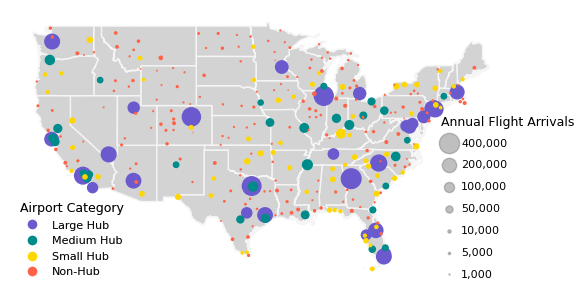

In [32]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.lines import Line2D


# Update this path to where you extracted the Natural Earth shapefile
shapefile_path = "./US_State_Boundaries/US_State_Boundaries.shp"

# Load the shapefile into a GeoDataFrame
us = gpd.read_file(shapefile_path)

# Filter for US mainland (excluding Alaska and Hawaii)
us_mainland = us[(us['NAME'] != 'Puerto Rico') & (us['NAME'] != 'Hawaii') & (us['NAME'] != 'Alaska') & (us['NAME'] !='U.S. Virgin Islands')]

# Set up plot
fig, ax = plt.subplots(figsize=(6, 4))

# Normalize size
max_size = annual_flight_count_mainland_FAA['flight_count'].max()
scale_factor = 200
normalize_size = lambda x: (x / max_size) * scale_factor

# Plot base map
us_mainland.plot(ax=ax, color='lightgrey', edgecolor='whitesmoke')

# Plot airport categories
annual_flight_count_mainland_large.plot(ax=ax, markersize=normalize_size(annual_flight_count_mainland_large['flight_count']), color='slateblue', label='Large Hub')
annual_flight_count_mainland_medium.plot(ax=ax, markersize=normalize_size(annual_flight_count_mainland_medium['flight_count']), color='darkcyan', label='Medium Hub')
annual_flight_count_mainland_small.plot(ax=ax, markersize=normalize_size(annual_flight_count_mainland_small['flight_count']), color='gold', label='Small Hub')
annual_flight_count_mainland_non_hub.plot(ax=ax, markersize=normalize_size(annual_flight_count_mainland_non_hub['flight_count']), color='tomato', label='Non-Hub')

# Custom legend for color (category)
color_legend = [
    Line2D([0], [0], marker='o', color='w', label='Large Hub', markerfacecolor='slateblue', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Medium Hub', markerfacecolor='darkcyan', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Small Hub', markerfacecolor='gold', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Non-Hub', markerfacecolor='tomato', markersize=8)
]
legend1 = ax.legend(handles=color_legend, title='Airport Category', loc = 'lower left', fontsize=8, title_fontsize=9)
ax.add_artist(legend1)
legend1.get_frame().set_linewidth(0)

# Custom size scale (marker size)
example_counts = [1000, 5000, 10000, 50000, 100000, 200000, 400000]  # adjust as needed
x_pos, y_pos = -125, 24  # adjust position to fit map
for i, count in enumerate(example_counts):
    y = y_pos + i * 2.2
    size = normalize_size(count)
    ax.scatter(x_pos+53, y, s=size, color='gray', alpha=0.5)
    ax.text(x_pos + 54.5, y, f'{count:,}', va='center', fontsize=8)

ax.text(x_pos+52, y_pos + len(example_counts)*2+1, 'Annual Flight Arrivals', fontsize=9)

# Remove border and axes
ax.set_axis_off()
plt.tight_layout()
plt.show()

### Figure 1a

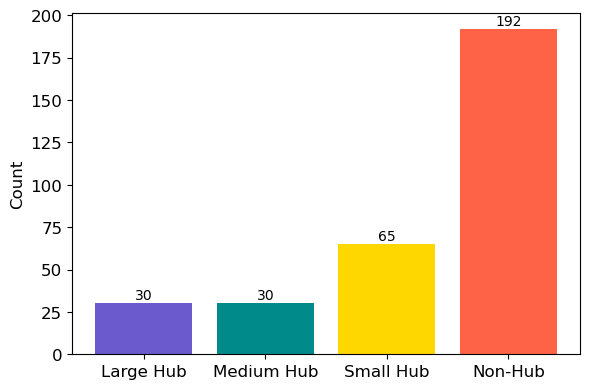

In [33]:
import matplotlib.pyplot as plt

# Data
categories = ['Large Hub', 'Medium Hub', 'Small Hub', 'Non-Hub']
values = [30, 30, 65, 192]

# Plot
plt.figure(figsize=(6, 4))
bars = plt.bar(categories, values, color=['slateblue', 'darkcyan', 'gold', 'tomato'])

# Add value labels above bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, str(yval), ha='center', va='bottom')

plt.ylabel('Count', fontsize = 12)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.tight_layout()

plt.show()

### Figure 1c

In [34]:
daily_flight_count_df

,Date (MM/DD/YYYY),flight_counts,airport
0,05/01/2023,25,ACK
1,05/02/2023,22,ACK
2,05/03/2023,27,ACK
3,05/04/2023,31,ACK
4,05/05/2023,29,ACK
...,...,...,...
360,12/27/2023,11,MLB
361,12/28/2023,8,MLB
362,12/29/2023,9,MLB
363,12/30/2023,11,MLB


In [35]:
annual_flight_count_mainland_non_hub.sort_values(by = 'flight_count')[-10:]

,airport,flight_count,iata_code,latitude_deg,longitude_deg,region_name,geometry,Airport Identifier (LOC ID),Hub Size
0,ACK,6549,ACK,41.25310135,-70.06020355,Massachusetts,POINT (-70.0602 41.2531),ACK,Non-Hub
303,AZA,6562,AZA,33.3078,-111.654999,Arizona,POINT (-111.655 33.3078),NaN,NaN
258,SHV,6566,SHV,32.446602,-93.8256,Louisiana,POINT (-93.8256 32.4466),SHV,Non-Hub
220,ABE,6635,ABE,40.651773,-75.442797,Pennsylvania,POINT (-75.4428 40.65177),ABE,Non-Hub
284,SBN,6848,SBN,41.708698,-86.317299,Indiana,POINT (-86.3173 41.7087),SBN,Non-Hub
27,ROA,7008,ROA,37.3255,-79.975403,Virginia,POINT (-79.9754 37.3255),ROA,Non-Hub
160,FWA,7034,FWA,40.9785,-85.195099,Indiana,POINT (-85.1951 40.9785),FWA,Non-Hub
180,TLH,7229,TLH,30.3965,-84.350304,Florida,POINT (-84.3503 30.3965),TLH,Non-Hub
113,RFD,10301,RFD,42.1954,-89.097198,Illinois,POINT (-89.0972 42.1954),RFD,Non-Hub
116,BIL,10612,BIL,45.807701,-108.542999,Montana,POINT (-108.543 45.8077),BIL,Non-Hub


In [36]:
# choose 5 airports from each category to represent daily flight arrival counts
large_5_airports = ['ATL', 'DEN', 'DFW', 'ORD', 'LAX', 'SFO', 'SEA', 'JFK', 'CLT', 'EWR']
medium_5_airports = ['MEM', 'PDX', 'DAL', 'CVG', 'STL', 'OAK', 'HOU', 'RDU', 'MCI', 'CLE']
small_5_airports = ['SDF', 'GEG', 'OKC', 'ORF', 'BUF', 'ELP', 'MYR', 'TYS', 'CAE', 'GRR']
nonhub_5_airports = ['BIL', 'RFD', 'TLH', 'FWA', 'ROA', 'AZA', 'SHV', 'ABE', 'SBN', 'ASE']

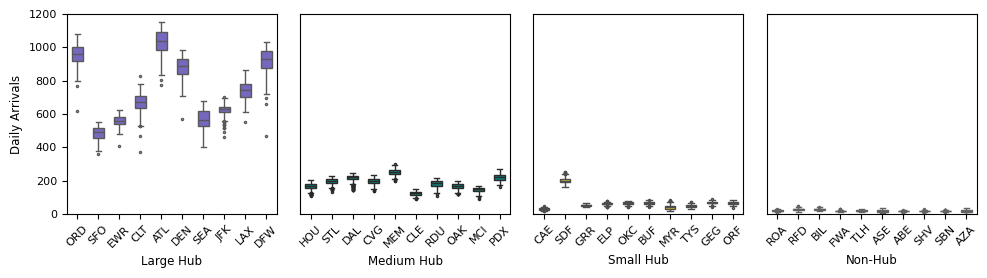

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert 'date' to datetime if not already
daily_flight_count_df['date'] = pd.to_datetime(daily_flight_count_df['Date (MM/DD/YYYY)'])

grouped_airports = {
'Large Hub': ['ATL', 'DEN', 'DFW', 'ORD', 'LAX', 'SFO', 'SEA', 'JFK', 'CLT', 'EWR'],
'Medium Hub': ['MEM', 'PDX', 'DAL', 'CVG', 'STL', 'OAK', 'HOU', 'RDU', 'MCI', 'CLE'],
'Small Hub': ['SDF', 'GEG', 'OKC', 'ORF', 'BUF', 'ELP', 'MYR', 'TYS', 'CAE', 'GRR'],
'Non-Hub': ['BIL', 'RFD', 'TLH', 'FWA', 'ROA', 'AZA', 'SHV', 'ABE', 'SBN', 'ASE']
}

colors = ['slateblue', 'darkcyan', 'gold', 'tomato']
# Create 4x1 subplots
fig, axes = plt.subplots(1, 4, figsize=(10, 3))
axes = axes.flatten()

# Plot one boxplot per group
for i, (category, airports) in enumerate(grouped_airports.items()):
    df_subset = daily_flight_count_df[daily_flight_count_df['airport'].isin(airports)]
    sns.boxplot(data=df_subset, x='airport', y='flight_counts', color = colors[i], ax=axes[i],fliersize=1.5,width=0.5)
    # axes[i].set_title(f"{category}", fontsize=12)
    axes[i].set_xlabel(f"{category}", fontsize=8.5)
    # axes[i].set_ylabel("Daily Arrivals")
    axes[i].tick_params(axis='x', labelsize =8, rotation=45) #rotation=45
    axes[i].set_ylim(0,1200)
    if i !=0:
        axes[i].set_ylabel("")
        axes[i].tick_params(axis='y', left=False, labelleft=False, labelsize =7)
    else:
        axes[i].tick_params(axis='y',labelsize =8)
        axes[i].set_ylabel("Daily Arrivals", fontsize = 8.5)

# Adjust layout
# plt.suptitle("Daily Flight Arrival Distributions by Airport Category", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Figure 1d

In [38]:
folder_path = Path('./all_flight_arrival_data_New')
airport_list = []
avg_hourly_flight_count_list = []
for file_path in folder_path.glob('*.csv'):
    all_flights = pd.read_csv(file_path)
    airport = all_flights['Destination Airport'].iloc[0]
    all_flights['hour'] = all_flights['Actual Arrival Time'].apply(lambda x: x.split(':')[0])
    hourly_flight_count = all_flights.groupby(['Date (MM/DD/YYYY)', 'hour']).size().reset_index(name='count')
    avg_hourly_flight_count = hourly_flight_count.groupby('hour')['count'].mean().reset_index()
    avg_hourly_flight_count['airport'] = airport
    avg_hourly_flight_count_list.append(avg_hourly_flight_count)

avg_hourly_flight_count_df = pd.concat(avg_hourly_flight_count_list)

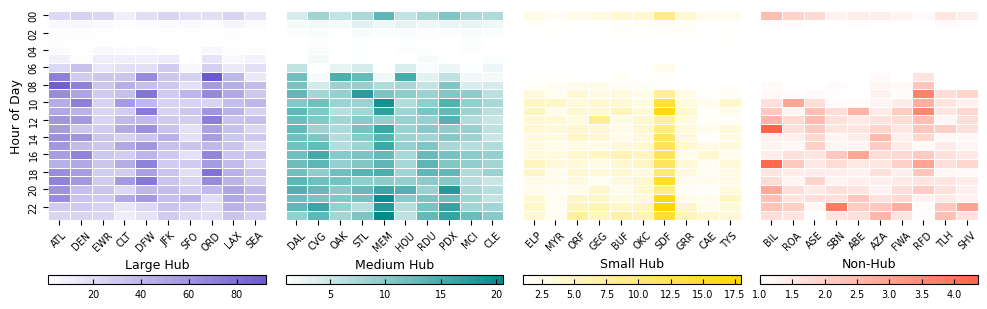

In [39]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import seaborn as sns

grouped_airports = {
    'Large Hub': ['ATL', 'DEN', 'EWR', 'CLT', 'DFW', 'JFK', 'SFO', 'ORD', 'LAX',  'SEA'],
    'Medium Hub': ['DAL', 'CVG', 'OAK', 'STL', 'MEM', 'HOU', 'RDU', 'PDX', 'MCI', 'CLE'],
    'Small Hub': ['ELP', 'MYR', 'ORF', 'GEG', 'BUF', 'OKC', 'SDF', 'GRR', 'CAE', 'TYS'],
    'Non-Hub': ['BIL', 'ROA', 'ASE', 'SBN', 'ABE', 'AZA', 'FWA', 'RFD', 'TLH', 'SHV']
}

# Define custom colormaps
cmap_large = LinearSegmentedColormap.from_list("slateblue_fade", ["white", "slateblue"])
cmap_medium = LinearSegmentedColormap.from_list("darkcyan_fade", ["white", "darkcyan"])
cmap_small = LinearSegmentedColormap.from_list("gold_fade", ["white", "gold"])
cmap_nonhub = LinearSegmentedColormap.from_list("tomato_fade", ["white", "tomato"])
cmaps = [cmap_large, cmap_medium, cmap_small, cmap_nonhub]

fig, axes = plt.subplots(1, 4, figsize=(10, 3.2), sharey=True)

for i, (category, airports) in enumerate(grouped_airports.items()):
    df_subset = avg_hourly_flight_count_df[avg_hourly_flight_count_df['airport'].isin(airports)]
    heatmap_data = df_subset.pivot(index="hour", columns="airport", values="count")[airports]

    # hm=sns.heatmap(
    #     heatmap_data,
    #     cmap=cmaps[i],
    #     linewidths=0.5,
    #     ax=axes[i],
    #     cbar=True,
    #     cbar_kws={'shrink': 0.6}
    # )
    # hm.collections[0].colorbar.ax.tick_params(labelsize=7)

    hm = sns.heatmap(
    heatmap_data,
    cmap=cmaps[i],
    linewidths=0.5,
    ax=axes[i],
    cbar=False  # disable default colorbar
    )

    # Add colorbar above the subplot
    cbar = fig.colorbar(
    hm.collections[0],
    ax=axes[i],
    orientation='horizontal',
    fraction=0.05,  # relative size of the colorbar
    pad=0.2,        # space between plot and colorbar
    aspect=25
    )
    cbar.ax.tick_params(labelsize=7, direction='in', labelbottom=True, labeltop=False)


    # # Get the colorbar
    # colorbar = hm.collections[0].colorbar

    # # Generate integer ticks within the value range
    # vmin = int(np.floor(colorbar.vmin))
    # vmax = int(np.ceil(colorbar.vmax))
    # ticks = list(range(vmin, vmax + 1, max(1, (vmax - vmin) // 4)))  # 4 steps max

    # axes[i].set_title(category, fontsize=10)
    axes[i].set_xlabel(f'{category}', fontsize=9)
    axes[i].tick_params(axis='x', labelsize=7, rotation=90)
    axes[i].set_xticks(np.arange(len(airports)) + 0.5)
    axes[i].set_xticklabels(airports, rotation=45, fontsize=7)

    if i == 0:
        axes[i].set_ylabel("Hour of Day", fontsize=9)
        axes[i].tick_params(axis='y', labelsize=7)
    else:
        axes[i].set_ylabel("")
        axes[i].tick_params(axis='y', left=False, labelleft=False)

plt.tight_layout() #rect=[0, 0, 1, 0.95]
plt.show()

### Figure 4

In [13]:
# vehicle and charger counts for each scenario
veh_folder = './all_flight_GSE_vehicle_count'
cha_folder = './all_flight_GSE_charger_count'

files_folder1 = [f for f in os.listdir(veh_folder) if f.endswith('.csv')]
files_folder2 = [f for f in os.listdir(cha_folder) if f.endswith('.csv')]

for file1 in files_folder1:

    common_string = file1.split('_')[-1].split('.')[0] 
    
    # Search for a corresponding file in folder2
    for file2 in files_folder2:
        if common_string in file2:
            # Read the CSV files
            df1 = pd.read_csv(os.path.join(veh_folder, file1))
            # df1 = df1[df1]
            df2 = pd.read_csv(os.path.join(cha_folder, file2))
            
            # Merge dataframes (you can specify how to merge based on your requirements)
            merged_df = pd.merge(df1, df2, on='airport', how='left')
            merged_df.to_csv(f'./all_flight_GSE_vehicle_count/veh_cha_count/veh_cha_count_{common_string}.csv')

In [14]:
veh_cha_count_S1 = pd.read_csv('./all_flight_GSE_vehicle_count/veh_cha_count/veh_cha_count_S1.csv')
veh_cha_count_S2 = pd.read_csv('./all_flight_GSE_vehicle_count/veh_cha_count/veh_cha_count_S2.csv')
veh_cha_count_S3 = pd.read_csv('./all_flight_GSE_vehicle_count/veh_cha_count/veh_cha_count_S3.csv')
veh_cha_count_S4 = pd.read_csv('./all_flight_GSE_vehicle_count/veh_cha_count/veh_cha_count_S4.csv')
veh_cha_count_S5 = pd.read_csv('./all_flight_GSE_vehicle_count/veh_cha_count/veh_cha_count_S5.csv')
veh_cha_count_S6 = pd.read_csv('./all_flight_GSE_vehicle_count/veh_cha_count/veh_cha_count_S6.csv')

In [15]:
veh_cha_count_S1['GPU_counts'] = veh_cha_count_S1['GPU_counts_narrow'] + veh_cha_count_S1['GPU_counts_wide']
veh_cha_count_S1['aircraft_tractor_counts'] = veh_cha_count_S1['aircraft_tractor_counts_narrow'] + veh_cha_count_S1['aircraft_tractor_counts_wide']
veh_cha_count_S1['belt_loader_counts'] = veh_cha_count_S1['belt_loader_counts_narrow'] + veh_cha_count_S1['belt_loader_counts_wide']
veh_cha_count_S1['lav_truck_counts'] = veh_cha_count_S1['lav_truck_counts_narrow'] + veh_cha_count_S1['lav_truck_counts_wide']
veh_cha_count_S1['water_truck_counts'] = veh_cha_count_S1['water_truck_counts_narrow'] + veh_cha_count_S1['water_truck_counts_wide']
veh_cha_count_S1['cargo_loader_counts'] = veh_cha_count_S1['cargo_loader_counts_wide']

In [22]:
veh_cha_count_S1_large = veh_cha_count_S1[veh_cha_count_S1['airport'].isin(annual_flight_count_mainland_large['airport'].to_list())]
veh_cha_count_S1_large['category'] = 'Large Hub'
veh_cha_count_S1_medium = veh_cha_count_S1[veh_cha_count_S1['airport'].isin(annual_flight_count_mainland_medium['airport'].to_list())]
veh_cha_count_S1_medium['category'] = 'Medium Hub'
veh_cha_count_S1_small = veh_cha_count_S1[veh_cha_count_S1['airport'].isin(annual_flight_count_mainland_small['airport'].to_list())]
veh_cha_count_S1_small['category'] = 'Small Hub'
veh_cha_count_S1_nonhub = veh_cha_count_S1[veh_cha_count_S1['airport'].isin(annual_flight_count_mainland_non_hub['airport'].to_list())]
veh_cha_count_S1_nonhub['category'] = 'Non-Hub'

/tmp/ipykernel_3815742/3641384872.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  veh_cha_count_S1_large['category'] = 'Large Hub'
/tmp/ipykernel_3815742/3641384872.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  veh_cha_count_S1_medium['category'] = 'Medium Hub'
/tmp/ipykernel_3815742/3641384872.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

0
[202.1, 129.2, 296.2, 36.46666666666667, 142.4, 169.2, 115.06666666666666, 110.6]
1
[77.8, 55.96666666666667, 121.23333333333333, 8.2, 59.96666666666667, 69.13333333333334, 49.1, 46.96666666666667]
2
[36.76923076923077, 28.46153846153846, 60.738461538461536, 2.953846153846154, 30.16923076923077, 34.30769230769231, 25.323076923076922, 24.70769230769231]
3
[10.65625, 8.822916666666666, 18.75, 0.9375, 9.229166666666666, 10.197916666666666, 8.041666666666666, 7.8125]


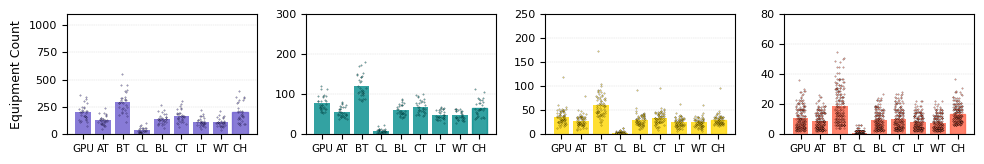

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

# Set the overall font and style
mpl.rcParams.update({
    'font.family': 'DejaVu Sans',
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 9,
    'xtick.labelsize': 7,
    'ytick.labelsize': 7,
    'legend.fontsize': 11,
    'axes.edgecolor': 'black',
    'axes.linewidth': 0.8,
    'grid.linewidth': 0.3,
    'grid.alpha': 0.3
})

# Combine all DataFrames
df = pd.concat([veh_cha_count_S1_large, veh_cha_count_S1_medium,
                veh_cha_count_S1_small, veh_cha_count_S1_nonhub], ignore_index=True)

gse_cols = [
    'GPU_counts', 'aircraft_tractor_counts', 'baggage_tractor_counts',
    'cargo_loader_counts', 'belt_loader_counts', 'cater_truck_counts',
    'lav_truck_counts', 'water_truck_counts'
]
charger_col = 'charger_count'
equipment_labels = gse_cols + ['Charger']
categories = ['Large Hub', 'Medium Hub', 'Small Hub', 'Non-Hub']

# Use more muted, professional colors
#colors = ['#4C72B0', '#55A868', '#C44E52', '#8172B2']
colors = ['slateblue', 'darkcyan', 'gold', 'tomato']

# Set x positions for the bars (one for each equipment type, including charger)
x = np.arange(len(equipment_labels))  # 9 equipment types
bar_width = 0.8  # Make the bar width wider (increased from 0.4)

# Create the subplots
fig, axes = plt.subplots(1, 4, figsize=(10, 1.8),sharey=False)
axes = axes.flatten()

# Iterate over categories and plot on corresponding axes
for i, cat in enumerate(categories):
    ax = axes[i]  # Get the appropriate axis for the current category
    print(i)

    # Bar plots for GSEs
    gse_vals = [df[df['category'] == cat][col].mean() for col in gse_cols]
    print(gse_vals)

    # Plot bars automatically with bar width and position adjustment
    ax.bar(x[:-1], gse_vals, width=bar_width, color=colors[i], label=cat, alpha=0.8, edgecolor='none')

    # Scatter plots for GSEs
    cat_df = df[df['category'] == cat]
    for j, col in enumerate(gse_cols):
        y_vals = cat_df[col].values
        x_base = x[j]  # We use x[j] directly as positions for GSE bars
        jitter = (np.random.rand(len(y_vals)) - 0.5) * bar_width * 0.6
        x_vals = np.full(len(y_vals), x_base) + jitter
        ax.scatter(x_vals, y_vals, color=colors[i], edgecolors='black', s=1, alpha=0.5, linewidths=0.3)

    # Bar plot for Charger (always at the last position)
    charger_val = df[df['category'] == cat][charger_col].mean()
    charger_bar = ax.bar(x[-1], charger_val, width=bar_width, color=colors[i], alpha=0.8, edgecolor=colors[i])

    # Scatter plots for Charger
    charger_vals = df[df['category'] == cat][charger_col].values
    jitter = (np.random.rand(len(charger_vals)) - 0.5) * bar_width * 0.6
    x_vals = np.full(len(charger_vals), x[-1]) + jitter
    ax.scatter(x_vals, charger_vals, color=colors[i], edgecolors='black', s=1, alpha=0.5, linewidths=0.3)

    # Aesthetics
    equip_list = ['GPU','Aircraft Tractor','Baggage Tractor','Cargo Loader','Belt Loader','Cater Truck','Lav Truck','Water Truck','Charger']
    equip_list_abb = ['GPU','AT','BT','CL','BL','CT','LT','WT','CH']
    ax.set_xticks(x)  # Now using the full range of x
    ax.set_xticklabels(equip_list_abb, rotation=0, ha='center', fontsize=7.5)  # Ensure center alignment
    axes[0].set_ylim(0, 1100)
    axes[1].set_ylim(0, 300)
    axes[2].set_ylim(0, 250)
    axes[3].set_ylim(0, 80)
    # ax.set_xlabel(cat, fontsize=9)
    ax.spines['top'].set_visible(True)  # Enable top border
    ax.spines['right'].set_visible(True)  # Enable right border
    ax.spines['bottom'].set_visible(True)  # Enable bottom border
    ax.spines['left'].set_visible(True)  # Enable left border
    ax.grid(True, axis='y', linestyle='--', alpha=0.5)  # Enable grid for each subplot

    # Set title for each subplot
    #ax.set_title(f'{cat} Equipment and Charger Counts')
    #ax.set_yscale('log')
    # Remove y-label for all but the first subplot
    if i != 0:
        ax.set_ylabel('')
    else:
        ax.set_ylabel('Equipment Count')
    ax.tick_params(axis='y', left=True, labelleft=True, labelsize =8)

    # # Add legend for the first subplot only
    # if i == 0:
    #     ax.legend(
    #         title='Airport Category',
    #         loc='upper center',
    #         bbox_to_anchor=(0.5, 1.13),  # adjust position above the plot
    #         ncol=len(categories),        # one column per category
    #         frameon=False,
    #         title_fontsize=12,
    #         fontsize=10
    #     )

# Adjust spacing between subplots and increase bottom space for better x-labels
plt.subplots_adjust(wspace=0.3, bottom=0.25)  # Increased bottom space to avoid label overlap

# Increase font size for the y-ticks if necessary
plt.tight_layout()
plt.show()


In [34]:
veh_cha_count_S2['GPU_counts'] = veh_cha_count_S2['GPU_counts_narrow'] + veh_cha_count_S2['GPU_counts_wide']
veh_cha_count_S2['aircraft_tractor_counts'] = veh_cha_count_S2['aircraft_tractor_counts_narrow'] + veh_cha_count_S2['aircraft_tractor_counts_wide']
veh_cha_count_S2['belt_loader_counts'] = veh_cha_count_S2['belt_loader_counts_narrow'] + veh_cha_count_S2['belt_loader_counts_wide']
veh_cha_count_S2['lav_truck_counts'] = veh_cha_count_S2['lav_truck_counts_narrow'] + veh_cha_count_S2['lav_truck_counts_wide']
veh_cha_count_S2['water_truck_counts'] = veh_cha_count_S2['water_truck_counts_narrow'] + veh_cha_count_S2['water_truck_counts_wide']
veh_cha_count_S2['cargo_loader_counts'] = veh_cha_count_S2['cargo_loader_counts_wide']

In [35]:
veh_cha_count_S2_large = veh_cha_count_S2[veh_cha_count_S2['airport'].isin(annual_flight_count_mainland_large['airport'].to_list())]
veh_cha_count_S2_large['category'] = 'Large Hub'
veh_cha_count_S2_medium = veh_cha_count_S2[veh_cha_count_S2['airport'].isin(annual_flight_count_mainland_medium['airport'].to_list())]
veh_cha_count_S2_medium['category'] = 'Medium Hub'
veh_cha_count_S2_small = veh_cha_count_S2[veh_cha_count_S2['airport'].isin(annual_flight_count_mainland_small['airport'].to_list())]
veh_cha_count_S2_small['category'] = 'Small Hub'
veh_cha_count_S2_nonhub = veh_cha_count_S2[veh_cha_count_S2['airport'].isin(annual_flight_count_mainland_non_hub['airport'].to_list())]
veh_cha_count_S2_nonhub['category'] = 'Non-Hub'

/tmp/ipykernel_3815742/2842693103.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  veh_cha_count_S2_large['category'] = 'Large Hub'
/tmp/ipykernel_3815742/2842693103.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  veh_cha_count_S2_medium['category'] = 'Medium Hub'
/tmp/ipykernel_3815742/2842693103.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

0
[262.53333333333336, 148.4, 314.76666666666665, 39.8, 144.63333333333333, 204.96666666666667, 118.73333333333333, 112.63333333333334]
1
[93.83333333333333, 63.13333333333333, 129.3, 8.466666666666667, 60.833333333333336, 79.96666666666667, 50.6, 48.166666666666664]
2
[42.738461538461536, 31.676923076923078, 63.96923076923077, 2.9846153846153847, 30.50769230769231, 38.63076923076923, 26.43076923076923, 25.215384615384615]
3
[11.807291666666666, 9.4375, 19.364583333333332, 0.9375, 9.276041666666666, 11.135416666666666, 8.265625, 8.005208333333334]


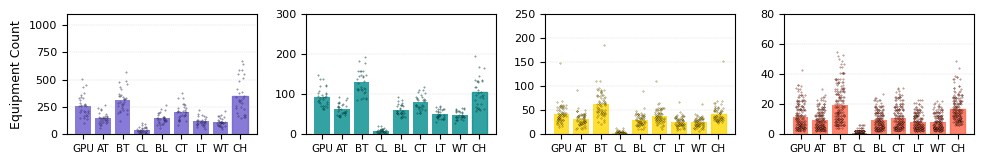

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

# Set the overall font and style
mpl.rcParams.update({
    'font.family': 'DejaVu Sans',
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 9,
    'xtick.labelsize': 7,
    'ytick.labelsize': 7,
    'legend.fontsize': 11,
    'axes.edgecolor': 'black',
    'axes.linewidth': 0.8,
    'grid.linewidth': 0.3,
    'grid.alpha': 0.3
})

# Combine all DataFrames
df = pd.concat([veh_cha_count_S2_large, veh_cha_count_S2_medium,
                veh_cha_count_S2_small, veh_cha_count_S2_nonhub], ignore_index=True)

gse_cols = [
    'GPU_counts', 'aircraft_tractor_counts', 'baggage_tractor_counts',
    'cargo_loader_counts', 'belt_loader_counts', 'cater_truck_counts',
    'lav_truck_counts', 'water_truck_counts'
]
charger_col = 'charger_count'
equipment_labels = gse_cols + ['Charger']
categories = ['Large Hub', 'Medium Hub', 'Small Hub', 'Non-Hub']

# Use more muted, professional colors
#colors = ['#4C72B0', '#55A868', '#C44E52', '#8172B2']
colors = ['slateblue', 'darkcyan', 'gold', 'tomato']

# Set x positions for the bars (one for each equipment type, including charger)
x = np.arange(len(equipment_labels))  # 9 equipment types
bar_width = 0.8  # Make the bar width wider (increased from 0.4)

# Create the subplots
fig, axes = plt.subplots(1, 4, figsize=(10, 1.8),sharey=False)
axes = axes.flatten()

# Iterate over categories and plot on corresponding axes
for i, cat in enumerate(categories):
    ax = axes[i]  # Get the appropriate axis for the current category
    print(i)

    # Bar plots for GSEs
    gse_vals = [df[df['category'] == cat][col].mean() for col in gse_cols]
    print(gse_vals)

    # Plot bars automatically with bar width and position adjustment
    ax.bar(x[:-1], gse_vals, width=bar_width, color=colors[i], label=cat, alpha=0.8, edgecolor='none')

    # Scatter plots for GSEs
    cat_df = df[df['category'] == cat]
    for j, col in enumerate(gse_cols):
        y_vals = cat_df[col].values
        x_base = x[j]  # We use x[j] directly as positions for GSE bars
        jitter = (np.random.rand(len(y_vals)) - 0.5) * bar_width * 0.6
        x_vals = np.full(len(y_vals), x_base) + jitter
        ax.scatter(x_vals, y_vals, color=colors[i], edgecolors='black', s=1, alpha=0.5, linewidths=0.3)

    # Bar plot for Charger (always at the last position)
    charger_val = df[df['category'] == cat][charger_col].mean()
    charger_bar = ax.bar(x[-1], charger_val, width=bar_width, color=colors[i], alpha=0.8, edgecolor=colors[i])

    # Scatter plots for Charger
    charger_vals = df[df['category'] == cat][charger_col].values
    jitter = (np.random.rand(len(charger_vals)) - 0.5) * bar_width * 0.6
    x_vals = np.full(len(charger_vals), x[-1]) + jitter
    ax.scatter(x_vals, charger_vals, color=colors[i], edgecolors='black', s=1, alpha=0.5, linewidths=0.3)

    # Aesthetics
    equip_list = ['GPU','Aircraft Tractor','Baggage Tractor','Cargo Loader','Belt Loader','Cater Truck','Lav Truck','Water Truck','Charger']
    equip_list_abb = ['GPU','AT','BT','CL','BL','CT','LT','WT','CH']
    ax.set_xticks(x)  # Now using the full range of x
    ax.set_xticklabels(equip_list_abb, rotation=0, ha='center', fontsize=7.5)  # Ensure center alignment
    axes[0].set_ylim(0, 1100)
    axes[1].set_ylim(0, 300)
    axes[2].set_ylim(0, 250)
    axes[3].set_ylim(0, 80)
    # ax.set_xlabel(cat, fontsize=9)
    ax.spines['top'].set_visible(True)  # Enable top border
    ax.spines['right'].set_visible(True)  # Enable right border
    ax.spines['bottom'].set_visible(True)  # Enable bottom border
    ax.spines['left'].set_visible(True)  # Enable left border
    ax.grid(True, axis='y', linestyle='--', alpha=0.5)  # Enable grid for each subplot

    # Set title for each subplot
    #ax.set_title(f'{cat} Equipment and Charger Counts')
    #ax.set_yscale('log')
    # Remove y-label for all but the first subplot
    if i != 0:
        ax.set_ylabel('')
    else:
        ax.set_ylabel('Equipment Count')

    ax.tick_params(axis='y', left=True, labelleft=True, labelsize =8)
    # # Add legend for the first subplot only
    # if i == 0:
    #     ax.legend(
    #         title='Airport Category',
    #         loc='upper center',
    #         bbox_to_anchor=(0.5, 1.13),  # adjust position above the plot
    #         ncol=len(categories),        # one column per category
    #         frameon=False,
    #         title_fontsize=12,
    #         fontsize=10
    #     )

# Adjust spacing between subplots and increase bottom space for better x-labels
plt.subplots_adjust(wspace=0.3, bottom=0.25)  # Increased bottom space to avoid label overlap

# Increase font size for the y-ticks if necessary
plt.tight_layout()
plt.show()


In [38]:
veh_cha_count_S3['GPU_counts'] = veh_cha_count_S3['GPU_counts_narrow'] + veh_cha_count_S3['GPU_counts_wide']
veh_cha_count_S3['aircraft_tractor_counts'] = veh_cha_count_S3['aircraft_tractor_counts_narrow'] + veh_cha_count_S3['aircraft_tractor_counts_wide']
veh_cha_count_S3['belt_loader_counts'] = veh_cha_count_S3['belt_loader_counts_narrow'] + veh_cha_count_S3['belt_loader_counts_wide']
veh_cha_count_S3['lav_truck_counts'] = veh_cha_count_S3['lav_truck_counts_narrow'] + veh_cha_count_S3['lav_truck_counts_wide']
veh_cha_count_S3['water_truck_counts'] = veh_cha_count_S3['water_truck_counts_narrow'] + veh_cha_count_S3['water_truck_counts_wide']
veh_cha_count_S3['cargo_loader_counts'] = veh_cha_count_S3['cargo_loader_counts_wide']

In [39]:
veh_cha_count_S3_large = veh_cha_count_S3[veh_cha_count_S3['airport'].isin(annual_flight_count_mainland_large['airport'].to_list())]
veh_cha_count_S3_large['category'] = 'Large Hub'
veh_cha_count_S3_medium = veh_cha_count_S3[veh_cha_count_S3['airport'].isin(annual_flight_count_mainland_medium['airport'].to_list())]
veh_cha_count_S3_medium['category'] = 'Medium Hub'
veh_cha_count_S3_small = veh_cha_count_S3[veh_cha_count_S3['airport'].isin(annual_flight_count_mainland_small['airport'].to_list())]
veh_cha_count_S3_small['category'] = 'Small Hub'
veh_cha_count_S3_nonhub = veh_cha_count_S3[veh_cha_count_S3['airport'].isin(annual_flight_count_mainland_non_hub['airport'].to_list())]
veh_cha_count_S3_nonhub['category'] = 'Non-Hub'

/tmp/ipykernel_3815742/520376927.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  veh_cha_count_S3_large['category'] = 'Large Hub'
/tmp/ipykernel_3815742/520376927.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  veh_cha_count_S3_medium['category'] = 'Medium Hub'
/tmp/ipykernel_3815742/520376927.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

0
[186.6, 117.03333333333333, 279.2, 32.46666666666667, 139.9, 146.33333333333334, 112.16666666666667, 108.1]
1
[67.96666666666667, 47.7, 111.4, 7.0, 59.4, 55.86666666666667, 46.93333333333333, 45.8]
2
[31.03076923076923, 24.476923076923075, 56.292307692307695, 2.8615384615384616, 29.923076923076923, 27.6, 24.43076923076923, 23.93846153846154]
3
[9.213541666666666, 7.833333333333333, 17.713541666666668, 0.9270833333333334, 9.182291666666666, 8.848958333333334, 7.848958333333333, 7.692708333333333]


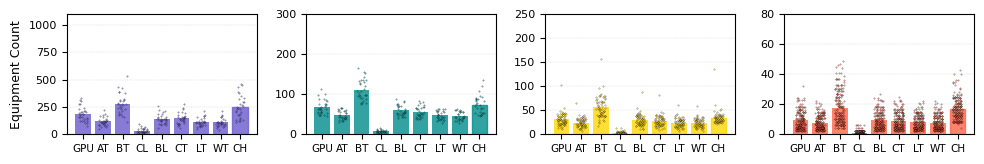

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

# Set the overall font and style
mpl.rcParams.update({
    'font.family': 'DejaVu Sans',
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 9,
    'xtick.labelsize': 7,
    'ytick.labelsize': 7,
    'legend.fontsize': 11,
    'axes.edgecolor': 'black',
    'axes.linewidth': 0.8,
    'grid.linewidth': 0.3,
    'grid.alpha': 0.3
})

# Combine all DataFrames
df = pd.concat([veh_cha_count_S3_large, veh_cha_count_S3_medium,
                veh_cha_count_S3_small, veh_cha_count_S3_nonhub], ignore_index=True)

gse_cols = [
    'GPU_counts', 'aircraft_tractor_counts', 'baggage_tractor_counts',
    'cargo_loader_counts', 'belt_loader_counts', 'cater_truck_counts',
    'lav_truck_counts', 'water_truck_counts'
]
charger_col = 'charger_count'
equipment_labels = gse_cols + ['Charger']
categories = ['Large Hub', 'Medium Hub', 'Small Hub', 'Non-Hub']

# Use more muted, professional colors
#colors = ['#4C72B0', '#55A868', '#C44E52', '#8172B2']
colors = ['slateblue', 'darkcyan', 'gold', 'tomato']

# Set x positions for the bars (one for each equipment type, including charger)
x = np.arange(len(equipment_labels))  # 9 equipment types
bar_width = 0.8  # Make the bar width wider (increased from 0.4)

# Create the subplots
fig, axes = plt.subplots(1, 4, figsize=(10, 1.8),sharey=False)
axes = axes.flatten()

# Iterate over categories and plot on corresponding axes
for i, cat in enumerate(categories):
    ax = axes[i]  # Get the appropriate axis for the current category
    print(i)

    # Bar plots for GSEs
    gse_vals = [df[df['category'] == cat][col].mean() for col in gse_cols]
    print(gse_vals)

    # Plot bars automatically with bar width and position adjustment
    ax.bar(x[:-1], gse_vals, width=bar_width, color=colors[i], label=cat, alpha=0.8, edgecolor='none')

    # Scatter plots for GSEs
    cat_df = df[df['category'] == cat]
    for j, col in enumerate(gse_cols):
        y_vals = cat_df[col].values
        x_base = x[j]  # We use x[j] directly as positions for GSE bars
        jitter = (np.random.rand(len(y_vals)) - 0.5) * bar_width * 0.6
        x_vals = np.full(len(y_vals), x_base) + jitter
        ax.scatter(x_vals, y_vals, color=colors[i], edgecolors='black', s=1, alpha=0.5, linewidths=0.3)

    # Bar plot for Charger (always at the last position)
    charger_val = df[df['category'] == cat][charger_col].mean()
    charger_bar = ax.bar(x[-1], charger_val, width=bar_width, color=colors[i], alpha=0.8, edgecolor=colors[i])

    # Scatter plots for Charger
    charger_vals = df[df['category'] == cat][charger_col].values
    jitter = (np.random.rand(len(charger_vals)) - 0.5) * bar_width * 0.6
    x_vals = np.full(len(charger_vals), x[-1]) + jitter
    ax.scatter(x_vals, charger_vals, color=colors[i], edgecolors='black', s=1, alpha=0.5, linewidths=0.3)

    # Aesthetics
    equip_list = ['GPU','Aircraft Tractor','Baggage Tractor','Cargo Loader','Belt Loader','Cater Truck','Lav Truck','Water Truck','Charger']
    equip_list_abb = ['GPU','AT','BT','CL','BL','CT','LT','WT','CH']
    ax.set_xticks(x)  # Now using the full range of x
    ax.set_xticklabels(equip_list_abb, rotation=0, ha='center', fontsize=7.5)  # Ensure center alignment
    axes[0].set_ylim(0, 1100)
    axes[1].set_ylim(0, 300)
    axes[2].set_ylim(0, 250)
    axes[3].set_ylim(0, 80)
    # ax.set_xlabel(cat, fontsize=9)
    ax.spines['top'].set_visible(True)  # Enable top border
    ax.spines['right'].set_visible(True)  # Enable right border
    ax.spines['bottom'].set_visible(True)  # Enable bottom border
    ax.spines['left'].set_visible(True)  # Enable left border
    ax.grid(True, axis='y', linestyle='--', alpha=0.5)  # Enable grid for each subplot

    # Set title for each subplot
    #ax.set_title(f'{cat} Equipment and Charger Counts')
    #ax.set_yscale('log')
    # Remove y-label for all but the first subplot

    ax.tick_params(axis='y', left=True, labelleft=True, labelsize =8)
    if i != 0:
        ax.set_ylabel('')
    else:
        ax.set_ylabel('Equipment Count')
    # # Add legend for the first subplot only
    # if i == 0:
    #     ax.legend(
    #         title='Airport Category',
    #         loc='upper center',
    #         bbox_to_anchor=(0.5, 1.13),  # adjust position above the plot
    #         ncol=len(categories),        # one column per category
    #         frameon=False,
    #         title_fontsize=12,
    #         fontsize=10
    #     )

# Adjust spacing between subplots and increase bottom space for better x-labels
plt.subplots_adjust(wspace=0.3, bottom=0.25)  # Increased bottom space to avoid label overlap

# Increase font size for the y-ticks if necessary
plt.tight_layout()
plt.show()


In [42]:
veh_cha_count_S4['GPU_counts'] = veh_cha_count_S4['GPU_counts_narrow'] + veh_cha_count_S4['GPU_counts_wide']
veh_cha_count_S4['aircraft_tractor_counts'] = veh_cha_count_S4['aircraft_tractor_counts_narrow'] + veh_cha_count_S4['aircraft_tractor_counts_wide']
veh_cha_count_S4['belt_loader_counts'] = veh_cha_count_S4['belt_loader_counts_narrow'] + veh_cha_count_S4['belt_loader_counts_wide']
veh_cha_count_S4['lav_truck_counts'] = veh_cha_count_S4['lav_truck_counts_narrow'] + veh_cha_count_S4['lav_truck_counts_wide']
veh_cha_count_S4['water_truck_counts'] = veh_cha_count_S4['water_truck_counts_narrow'] + veh_cha_count_S4['water_truck_counts_wide']
veh_cha_count_S4['cargo_loader_counts'] = veh_cha_count_S4['cargo_loader_counts_wide']

In [43]:
veh_cha_count_S4_large = veh_cha_count_S4[veh_cha_count_S4['airport'].isin(annual_flight_count_mainland_large['airport'].to_list())]
veh_cha_count_S4_large['category'] = 'Large Hub'
veh_cha_count_S4_medium = veh_cha_count_S4[veh_cha_count_S4['airport'].isin(annual_flight_count_mainland_medium['airport'].to_list())]
veh_cha_count_S4_medium['category'] = 'Medium Hub'
veh_cha_count_S4_small = veh_cha_count_S4[veh_cha_count_S4['airport'].isin(annual_flight_count_mainland_small['airport'].to_list())]
veh_cha_count_S4_small['category'] = 'Small Hub'
veh_cha_count_S4_nonhub = veh_cha_count_S4[veh_cha_count_S4['airport'].isin(annual_flight_count_mainland_non_hub['airport'].to_list())]
veh_cha_count_S4_nonhub['category'] = 'Non-Hub'

/tmp/ipykernel_3815742/336120556.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  veh_cha_count_S4_large['category'] = 'Large Hub'
/tmp/ipykernel_3815742/336120556.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  veh_cha_count_S4_medium['category'] = 'Medium Hub'
/tmp/ipykernel_3815742/336120556.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

0
[242.06666666666666, 129.1, 286.2, 34.8, 141.2, 166.2, 112.63333333333334, 108.3]
1
[80.16666666666667, 49.96666666666667, 112.6, 7.066666666666666, 59.6, 59.13333333333333, 46.96666666666667, 45.8]
2
[34.707692307692305, 24.76923076923077, 56.41538461538462, 2.8615384615384616, 29.923076923076923, 27.953846153846154, 24.43076923076923, 23.93846153846154]
3
[9.791666666666666, 7.864583333333333, 17.734375, 0.9270833333333334, 9.182291666666666, 8.848958333333334, 7.848958333333333, 7.692708333333333]


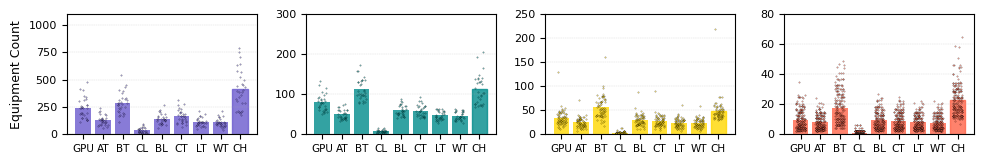

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

# Set the overall font and style
mpl.rcParams.update({
    'font.family': 'DejaVu Sans',
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 9,
    'xtick.labelsize': 7,
    'ytick.labelsize': 7,
    'legend.fontsize': 11,
    'axes.edgecolor': 'black',
    'axes.linewidth': 0.8,
    'grid.linewidth': 0.3,
    'grid.alpha': 0.3
})

# Combine all DataFrames
df = pd.concat([veh_cha_count_S4_large, veh_cha_count_S4_medium,
                veh_cha_count_S4_small, veh_cha_count_S4_nonhub], ignore_index=True)

gse_cols = [
    'GPU_counts', 'aircraft_tractor_counts', 'baggage_tractor_counts',
    'cargo_loader_counts', 'belt_loader_counts', 'cater_truck_counts',
    'lav_truck_counts', 'water_truck_counts'
]
charger_col = 'charger_count'
equipment_labels = gse_cols + ['Charger']
categories = ['Large Hub', 'Medium Hub', 'Small Hub', 'Non-Hub']

# Use more muted, professional colors
#colors = ['#4C72B0', '#55A868', '#C44E52', '#8172B2']
colors = ['slateblue', 'darkcyan', 'gold', 'tomato']

# Set x positions for the bars (one for each equipment type, including charger)
x = np.arange(len(equipment_labels))  # 9 equipment types
bar_width = 0.8  # Make the bar width wider (increased from 0.4)

# Create the subplots
fig, axes = plt.subplots(1, 4, figsize=(10, 1.8),sharey=False)
axes = axes.flatten()

# Iterate over categories and plot on corresponding axes
for i, cat in enumerate(categories):
    ax = axes[i]  # Get the appropriate axis for the current category
    print(i)

    # Bar plots for GSEs
    gse_vals = [df[df['category'] == cat][col].mean() for col in gse_cols]
    print(gse_vals)

    # Plot bars automatically with bar width and position adjustment
    ax.bar(x[:-1], gse_vals, width=bar_width, color=colors[i], label=cat, alpha=0.8, edgecolor='none')

    # Scatter plots for GSEs
    cat_df = df[df['category'] == cat]
    for j, col in enumerate(gse_cols):
        y_vals = cat_df[col].values
        x_base = x[j]  # We use x[j] directly as positions for GSE bars
        jitter = (np.random.rand(len(y_vals)) - 0.5) * bar_width * 0.6
        x_vals = np.full(len(y_vals), x_base) + jitter
        ax.scatter(x_vals, y_vals, color=colors[i], edgecolors='black', s=1, alpha=0.5, linewidths=0.3)

    # Bar plot for Charger (always at the last position)
    charger_val = df[df['category'] == cat][charger_col].mean()
    charger_bar = ax.bar(x[-1], charger_val, width=bar_width, color=colors[i], alpha=0.8, edgecolor=colors[i])

    # Scatter plots for Charger
    charger_vals = df[df['category'] == cat][charger_col].values
    jitter = (np.random.rand(len(charger_vals)) - 0.5) * bar_width * 0.6
    x_vals = np.full(len(charger_vals), x[-1]) + jitter
    ax.scatter(x_vals, charger_vals, color=colors[i], edgecolors='black', s=1, alpha=0.5, linewidths=0.3)

    # Aesthetics
    equip_list = ['GPU','Aircraft Tractor','Baggage Tractor','Cargo Loader','Belt Loader','Cater Truck','Lav Truck','Water Truck','Charger']
    equip_list_abb = ['GPU','AT','BT','CL','BL','CT','LT','WT','CH']
    ax.set_xticks(x)  # Now using the full range of x
    ax.set_xticklabels(equip_list_abb, rotation=0, ha='center', fontsize=7.5)  # Ensure center alignment
    # ax.set_ylim(0, 1200)
    # ax.set_xlabel(cat, fontsize=9)
    ax.spines['top'].set_visible(True)  # Enable top border
    ax.spines['right'].set_visible(True)  # Enable right border
    ax.spines['bottom'].set_visible(True)  # Enable bottom border
    ax.spines['left'].set_visible(True)  # Enable left border
    ax.grid(True, axis='y', linestyle='--', alpha=0.5)  # Enable grid for each subplot
    axes[0].set_ylim(0, 1100)
    axes[1].set_ylim(0, 300)
    axes[2].set_ylim(0, 250)
    axes[3].set_ylim(0, 80)

    # Set title for each subplot
    #ax.set_title(f'{cat} Equipment and Charger Counts')
    #ax.set_yscale('log')
    # Remove y-label for all but the first subplot
    ax.tick_params(axis='y', left=True, labelleft=True, labelsize =8)
    if i != 0:
        ax.set_ylabel('')
    else:
        ax.set_ylabel('Equipment Count')
    # # Add legend for the first subplot only
    # if i == 0:
    #     ax.legend(
    #         title='Airport Category',
    #         loc='upper center',
    #         bbox_to_anchor=(0.5, 1.13),  # adjust position above the plot
    #         ncol=len(categories),        # one column per category
    #         frameon=False,
    #         title_fontsize=12,
    #         fontsize=10
    #     )

# Adjust spacing between subplots and increase bottom space for better x-labels
plt.subplots_adjust(wspace=0.3, bottom=0.25)  # Increased bottom space to avoid label overlap

# Increase font size for the y-ticks if necessary
plt.tight_layout()
plt.show()


In [45]:
veh_cha_count_S5['GPU_counts'] = veh_cha_count_S5['GPU_counts_narrow'] + veh_cha_count_S5['GPU_counts_wide']
veh_cha_count_S5['aircraft_tractor_counts'] = veh_cha_count_S5['aircraft_tractor_counts_narrow'] + veh_cha_count_S5['aircraft_tractor_counts_wide']
veh_cha_count_S5['belt_loader_counts'] = veh_cha_count_S5['belt_loader_counts_narrow'] + veh_cha_count_S5['belt_loader_counts_wide']
veh_cha_count_S5['lav_truck_counts'] = veh_cha_count_S5['lav_truck_counts_narrow'] + veh_cha_count_S5['lav_truck_counts_wide']
veh_cha_count_S5['water_truck_counts'] = veh_cha_count_S5['water_truck_counts_narrow'] + veh_cha_count_S5['water_truck_counts_wide']
veh_cha_count_S5['cargo_loader_counts'] = veh_cha_count_S5['cargo_loader_counts_wide']

In [46]:
veh_cha_count_S5_large = veh_cha_count_S5[veh_cha_count_S5['airport'].isin(annual_flight_count_mainland_large['airport'].to_list())]
veh_cha_count_S5_large['category'] = 'Large Hub'
veh_cha_count_S5_medium = veh_cha_count_S5[veh_cha_count_S5['airport'].isin(annual_flight_count_mainland_medium['airport'].to_list())]
veh_cha_count_S5_medium['category'] = 'Medium Hub'
veh_cha_count_S5_small = veh_cha_count_S5[veh_cha_count_S5['airport'].isin(annual_flight_count_mainland_small['airport'].to_list())]
veh_cha_count_S5_small['category'] = 'Small Hub'
veh_cha_count_S5_nonhub = veh_cha_count_S5[veh_cha_count_S5['airport'].isin(annual_flight_count_mainland_non_hub['airport'].to_list())]
veh_cha_count_S5_nonhub['category'] = 'Non-Hub'

/tmp/ipykernel_3815742/1382150644.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  veh_cha_count_S5_large['category'] = 'Large Hub'
/tmp/ipykernel_3815742/1382150644.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  veh_cha_count_S5_medium['category'] = 'Medium Hub'
/tmp/ipykernel_3815742/1382150644.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

0
[437.73333333333335, 269.8, 507.8666666666667, 64.8, 188.2, 224.13333333333333, 149.36666666666667, 133.33333333333334]
1
[136.86666666666667, 100.53333333333333, 183.86666666666667, 10.733333333333333, 70.26666666666667, 86.26666666666667, 64.73333333333333, 58.43333333333333]
2
[53.89230769230769, 43.646153846153844, 85.41538461538461, 3.2, 33.95384615384615, 40.63076923076923, 32.53846153846154, 30.03076923076923]
3
[13.71875, 12.088541666666666, 23.661458333333332, 1.0, 9.854166666666666, 11.510416666666666, 9.484375, 8.979166666666666]


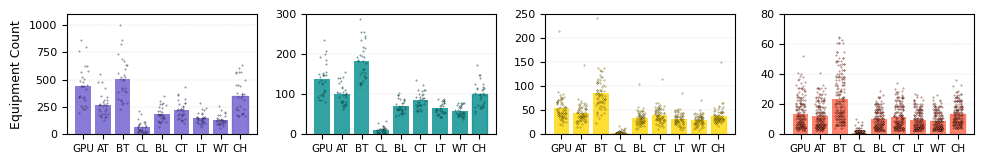

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

# Set the overall font and style
mpl.rcParams.update({
    'font.family': 'DejaVu Sans',
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 9,
    'xtick.labelsize': 7,
    'ytick.labelsize': 7,
    'legend.fontsize': 11,
    'axes.edgecolor': 'black',
    'axes.linewidth': 0.8,
    'grid.linewidth': 0.3,
    'grid.alpha': 0.3
})

# Combine all DataFrames
df = pd.concat([veh_cha_count_S5_large, veh_cha_count_S5_medium,
                veh_cha_count_S5_small, veh_cha_count_S5_nonhub], ignore_index=True)

gse_cols = [
    'GPU_counts', 'aircraft_tractor_counts', 'baggage_tractor_counts',
    'cargo_loader_counts', 'belt_loader_counts', 'cater_truck_counts',
    'lav_truck_counts', 'water_truck_counts'
]
charger_col = 'charger_count'
equipment_labels = gse_cols + ['Charger']
categories = ['Large Hub', 'Medium Hub', 'Small Hub', 'Non-Hub']

# Use more muted, professional colors
#colors = ['#4C72B0', '#55A868', '#C44E52', '#8172B2']
colors = ['slateblue', 'darkcyan', 'gold', 'tomato']

# Set x positions for the bars (one for each equipment type, including charger)
x = np.arange(len(equipment_labels))  # 9 equipment types
bar_width = 0.8  # Make the bar width wider (increased from 0.4)

# Create the subplots
fig, axes = plt.subplots(1, 4, figsize=(10, 1.8),sharey=False)
axes = axes.flatten()

# Iterate over categories and plot on corresponding axes
for i, cat in enumerate(categories):
    ax = axes[i]  # Get the appropriate axis for the current category
    print(i)

    # Bar plots for GSEs
    gse_vals = [df[df['category'] == cat][col].mean() for col in gse_cols]
    print(gse_vals)

    # Plot bars automatically with bar width and position adjustment
    ax.bar(x[:-1], gse_vals, width=bar_width, color=colors[i], label=cat, alpha=0.8, edgecolor='none')

    # Scatter plots for GSEs
    cat_df = df[df['category'] == cat]
    for j, col in enumerate(gse_cols):
        y_vals = cat_df[col].values
        x_base = x[j]  # We use x[j] directly as positions for GSE bars
        jitter = (np.random.rand(len(y_vals)) - 0.5) * bar_width * 0.6
        x_vals = np.full(len(y_vals), x_base) + jitter
        ax.scatter(x_vals, y_vals, color=colors[i], edgecolors='black', s=1, alpha=0.5, linewidths=0.3)

    # Bar plot for Charger (always at the last position)
    charger_val = df[df['category'] == cat][charger_col].mean()
    charger_bar = ax.bar(x[-1], charger_val, width=bar_width, color=colors[i], alpha=0.8, edgecolor=colors[i])

    # Scatter plots for Charger
    charger_vals = df[df['category'] == cat][charger_col].values
    jitter = (np.random.rand(len(charger_vals)) - 0.5) * bar_width * 0.6
    x_vals = np.full(len(charger_vals), x[-1]) + jitter
    ax.scatter(x_vals, charger_vals, color=colors[i], edgecolors='black', s=1, alpha=0.5, linewidths=0.3)

    # Aesthetics
    equip_list = ['GPU','Aircraft Tractor','Baggage Tractor','Cargo Loader','Belt Loader','Cater Truck','Lav Truck','Water Truck','Charger']
    equip_list_abb = ['GPU','AT','BT','CL','BL','CT','LT','WT','CH']
    ax.set_xticks(x)  # Now using the full range of x
    ax.set_xticklabels(equip_list_abb, rotation=0, ha='center', fontsize=7.5)  # Ensure center alignment
    # ax.set_ylim(0, 1200)
    # ax.set_xlabel(cat, fontsize=9)
    ax.spines['top'].set_visible(True)  # Enable top border
    ax.spines['right'].set_visible(True)  # Enable right border
    ax.spines['bottom'].set_visible(True)  # Enable bottom border
    ax.spines['left'].set_visible(True)  # Enable left border
    ax.grid(True, axis='y', linestyle='--', alpha=0.5)  # Enable grid for each subplot
    axes[0].set_ylim(0, 1100)
    axes[1].set_ylim(0, 300)
    axes[2].set_ylim(0, 250)
    axes[3].set_ylim(0, 80)

    # Set title for each subplot
    #ax.set_title(f'{cat} Equipment and Charger Counts')
    #ax.set_yscale('log')
    # Remove y-label for all but the first subplot
    ax.tick_params(axis='y', left=True, labelleft=True, labelsize =8)
    if i != 0:
        ax.set_ylabel('')
    else:
        ax.set_ylabel('Equipment Count')
    # # Add legend for the first subplot only
    # if i == 0:
    #     ax.legend(
    #         title='Airport Category',
    #         loc='upper center',
    #         bbox_to_anchor=(0.5, 1.13),  # adjust position above the plot
    #         ncol=len(categories),        # one column per category
    #         frameon=False,
    #         title_fontsize=12,
    #         fontsize=10
    #     )

# Adjust spacing between subplots and increase bottom space for better x-labels
plt.subplots_adjust(wspace=0.3, bottom=0.25)  # Increased bottom space to avoid label overlap

# Increase font size for the y-ticks if necessary
plt.tight_layout()
plt.show()


In [58]:
veh_cha_count_S6['GPU_counts'] = veh_cha_count_S6['GPU_counts_narrow'] + veh_cha_count_S6['GPU_counts_wide']
veh_cha_count_S6['aircraft_tractor_counts'] = veh_cha_count_S6['aircraft_tractor_counts_narrow'] + veh_cha_count_S6['aircraft_tractor_counts_wide']
veh_cha_count_S6['belt_loader_counts'] = veh_cha_count_S6['belt_loader_counts_narrow'] + veh_cha_count_S6['belt_loader_counts_wide']
veh_cha_count_S6['lav_truck_counts'] = veh_cha_count_S6['lav_truck_counts_narrow'] + veh_cha_count_S6['lav_truck_counts_wide']
veh_cha_count_S6['water_truck_counts'] = veh_cha_count_S6['water_truck_counts_narrow'] + veh_cha_count_S6['water_truck_counts_wide']
veh_cha_count_S6['cargo_loader_counts'] = veh_cha_count_S6['cargo_loader_counts_wide']

In [59]:
veh_cha_count_S6_large = veh_cha_count_S6[veh_cha_count_S6['airport'].isin(annual_flight_count_mainland_large['airport'].to_list())]
veh_cha_count_S6_large['category'] = 'Large Hub'
veh_cha_count_S6_medium = veh_cha_count_S6[veh_cha_count_S6['airport'].isin(annual_flight_count_mainland_medium['airport'].to_list())]
veh_cha_count_S6_medium['category'] = 'Medium Hub'
veh_cha_count_S6_small = veh_cha_count_S6[veh_cha_count_S6['airport'].isin(annual_flight_count_mainland_small['airport'].to_list())]
veh_cha_count_S6_small['category'] = 'Small Hub'
veh_cha_count_S6_nonhub = veh_cha_count_S6[veh_cha_count_S6['airport'].isin(annual_flight_count_mainland_non_hub['airport'].to_list())]
veh_cha_count_S6_nonhub['category'] = 'Non-Hub'

/tmp/ipykernel_3815742/756021145.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  veh_cha_count_S6_large['category'] = 'Large Hub'
/tmp/ipykernel_3815742/756021145.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  veh_cha_count_S6_medium['category'] = 'Medium Hub'
/tmp/ipykernel_3815742/756021145.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

0
[440.23333333333335, 281.7, 521.9, 65.53333333333333, 189.73333333333332, 228.5, 149.43333333333334, 133.93333333333334]
1
[137.4, 102.63333333333334, 187.33333333333334, 10.8, 70.3, 86.86666666666666, 64.96666666666667, 59.1]
2
[53.784615384615385, 44.47692307692308, 86.43076923076923, 3.2, 34.04615384615385, 40.784615384615385, 32.69230769230769, 30.184615384615384]
3
[13.723958333333334, 12.307291666666666, 23.817708333333332, 1.0, 9.885416666666666, 11.567708333333334, 9.53125, 9.015625]


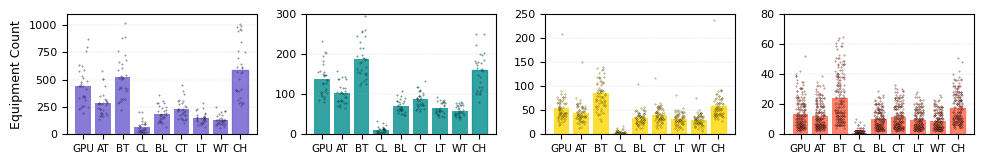

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

# Set the overall font and style
mpl.rcParams.update({
    'font.family': 'DejaVu Sans',
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 9,
    'xtick.labelsize': 7,
    'ytick.labelsize': 7,
    'legend.fontsize': 11,
    'axes.edgecolor': 'black',
    'axes.linewidth': 0.8,
    'grid.linewidth': 0.3,
    'grid.alpha': 0.3
})

# Combine all DataFrames
df = pd.concat([veh_cha_count_S6_large, veh_cha_count_S6_medium,
                veh_cha_count_S6_small, veh_cha_count_S6_nonhub], ignore_index=True)

gse_cols = [
    'GPU_counts', 'aircraft_tractor_counts', 'baggage_tractor_counts',
    'cargo_loader_counts', 'belt_loader_counts', 'cater_truck_counts',
    'lav_truck_counts', 'water_truck_counts'
]
charger_col = 'charger_count'
equipment_labels = gse_cols + ['Charger']
categories = ['Large Hub', 'Medium Hub', 'Small Hub', 'Non-Hub']

# Use more muted, professional colors
#colors = ['#4C72B0', '#55A868', '#C44E52', '#8172B2']
colors = ['slateblue', 'darkcyan', 'gold', 'tomato']

# Set x positions for the bars (one for each equipment type, including charger)
x = np.arange(len(equipment_labels))  # 9 equipment types
bar_width = 0.8  # Make the bar width wider (increased from 0.4)

# Create the subplots
fig, axes = plt.subplots(1, 4, figsize=(10, 1.8),sharey=False)
axes = axes.flatten()

# Iterate over categories and plot on corresponding axes
for i, cat in enumerate(categories):
    ax = axes[i]  # Get the appropriate axis for the current category
    print(i)

    # Bar plots for GSEs
    gse_vals = [df[df['category'] == cat][col].mean() for col in gse_cols]
    print(gse_vals)

    # Plot bars automatically with bar width and position adjustment
    ax.bar(x[:-1], gse_vals, width=bar_width, color=colors[i], label=cat, alpha=0.8, edgecolor='none')

    # Scatter plots for GSEs
    cat_df = df[df['category'] == cat]
    for j, col in enumerate(gse_cols):
        y_vals = cat_df[col].values
        x_base = x[j]  # We use x[j] directly as positions for GSE bars
        jitter = (np.random.rand(len(y_vals)) - 0.5) * bar_width * 0.6
        x_vals = np.full(len(y_vals), x_base) + jitter
        ax.scatter(x_vals, y_vals, color=colors[i], edgecolors='black', s=1, alpha=0.5, linewidths=0.3)

    # Bar plot for Charger (always at the last position)
    charger_val = df[df['category'] == cat][charger_col].mean()
    charger_bar = ax.bar(x[-1], charger_val, width=bar_width, color=colors[i], alpha=0.8, edgecolor=colors[i])

    # Scatter plots for Charger
    charger_vals = df[df['category'] == cat][charger_col].values
    jitter = (np.random.rand(len(charger_vals)) - 0.5) * bar_width * 0.6
    x_vals = np.full(len(charger_vals), x[-1]) + jitter
    ax.scatter(x_vals, charger_vals, color=colors[i], edgecolors='black', s=1, alpha=0.5, linewidths=0.3)

    # Aesthetics
    equip_list = ['GPU','Aircraft Tractor','Baggage Tractor','Cargo Loader','Belt Loader','Cater Truck','Lav Truck','Water Truck','Charger']
    equip_list_abb = ['GPU','AT','BT','CL','BL','CT','LT','WT','CH']
    ax.set_xticks(x)  # Now using the full range of x
    ax.set_xticklabels(equip_list_abb, rotation=0, ha='center', fontsize=7.5)  # Ensure center alignment
    # ax.set_ylim(0, 1200)
    # ax.set_xlabel(cat, fontsize=10)
    ax.spines['top'].set_visible(True)  # Enable top border
    ax.spines['right'].set_visible(True)  # Enable right border
    ax.spines['bottom'].set_visible(True)  # Enable bottom border
    ax.spines['left'].set_visible(True)  # Enable left border
    ax.grid(True, axis='y', linestyle='--', alpha=0.5)  # Enable grid for each subplot
    axes[0].set_ylim(0, 1100)
    axes[1].set_ylim(0, 300)
    axes[2].set_ylim(0, 250)
    axes[3].set_ylim(0, 80)

    # Set title for each subplot
    #ax.set_title(f'{cat} Equipment and Charger Counts')
    #ax.set_yscale('log')
    # Remove y-label for all but the first subplot
    ax.tick_params(axis='y', left=True, labelleft=True, labelsize =8)
    if i != 0:
        ax.set_ylabel('')
    else:
        ax.set_ylabel('Equipment Count')
    # # Add legend for the first subplot only
    # if i == 0:
    #     ax.legend(
    #         title='Airport Category',
    #         loc='upper center',
    #         bbox_to_anchor=(0.5, 1.13),  # adjust position above the plot
    #         ncol=len(categories),        # one column per category
    #         frameon=False,
    #         title_fontsize=12,
    #         fontsize=10
    #     )

# Adjust spacing between subplots and increase bottom space for better x-labels
plt.subplots_adjust(wspace=0.3, bottom=0.25)  # Increased bottom space to avoid label overlap

# Increase font size for the y-ticks if necessary
plt.tight_layout()
plt.show()


### Table 2

In [61]:
# # get energy consumption for all the airports
# import glob
# folder_path = Path('./all_flight_GSE_tasks')
# GSE_tasks = glob.glob(os.path.join(folder_path, '*.csv'))
# for file_path in GSE_tasks:
#     df_temp = pd.read_csv(file_path, parse_dates=['start_time', 'end_time'])
#     df_temp['start_time'] = pd.to_datetime(df_temp['start_time'])
#     df_temp['date'] = df_temp['start_time'].dt.date
#     enery_day = df_temp.groupby('date').agg({'energy_consumption': 'sum'}).reset_index()
#     airport = os.path.basename(file_path).split('_')[0]
#     enery_day.to_csv(f'./all_flight_energy_consumption/{airport}_daily_GSE_energy.csv')

In [62]:
folder_path = Path('./all_flight_energy_consumption')
energy_consumption = glob.glob(os.path.join(folder_path, '*.csv'))

airport_list = []
annual_energy_list = []
avg_daily_energy_list = []
for file_path in energy_consumption:
    df_temp = pd.read_csv(file_path)
    airport = os.path.basename(file_path).split('_')[0]
    annual_energy = df_temp['energy_consumption'].sum()
    avg_daily_energy = df_temp['energy_consumption'].mean()
    airport_list.append(airport)
    annual_energy_list.append(annual_energy)
    avg_daily_energy_list.append(avg_daily_energy)

energy_df = pd.DataFrame({'airport':airport_list, 'annual_energy': annual_energy_list, 'avg_daily_energy': avg_daily_energy_list})

In [64]:
energy_df_317 = energy_df[energy_df['airport'].isin(annual_flight_count_mainland_FAA['airport'].to_list())]

In [65]:
energy_df_317_large = energy_df_317[energy_df_317['airport'].isin(annual_flight_count_mainland_large['airport'].to_list())]
energy_df_317_medium = energy_df_317[energy_df_317['airport'].isin(annual_flight_count_mainland_medium['airport'].to_list())]
energy_df_317_small = energy_df_317[energy_df_317['airport'].isin(annual_flight_count_mainland_small['airport'].to_list())]
energy_df_317_nonhub = energy_df_317[energy_df_317['airport'].isin(annual_flight_count_mainland_non_hub['airport'].to_list())]

In [66]:
energy_df_317_large['annual_energy'].max()

50877596.89258334

In [67]:
energy_df_317_large['annual_energy'].min()

10818860.254250001

In [68]:
energy_df_317_large['annual_energy'].mean()

26709038.806311112

In [69]:
energy_df_317_medium['annual_energy'].max()

12102075.0125

In [70]:
energy_df_317_medium['annual_energy'].min()

2940516.6373333335

In [71]:
energy_df_317_medium['annual_energy'].mean()

5934429.712575

In [72]:
energy_df_317_small['annual_energy'].max()

9238625.387249999

In [73]:
energy_df_317_small['annual_energy'].min()

577366.4779166667

In [74]:
energy_df_317_small['annual_energy'].mean()

1617352.5571858974

In [75]:
energy_df_317_nonhub['annual_energy'].max()

1204434.393416667

In [76]:
energy_df_317_nonhub['annual_energy'].min()

8056.790083333333

In [77]:
energy_df_317_nonhub['annual_energy'].mean()

265419.14039930556

In [78]:
energy_df_317_large['avg_daily_energy'].max()

138631.05420322437

In [79]:
energy_df_317_large['avg_daily_energy'].min()

29479.1832540872

In [80]:
energy_df_317_large['avg_daily_energy'].mean()

72776.67249676053

In [81]:
energy_df_317_medium['avg_daily_energy'].max()

33065.77872267759

In [82]:
energy_df_317_medium['avg_daily_energy'].min()

8034.198462659381

In [83]:
energy_df_317_medium['avg_daily_energy'].mean()

16182.448970606825

In [84]:
energy_df_317_small['avg_daily_energy'].max()

25173.366177792912

In [85]:
energy_df_317_small['avg_daily_energy'].min()

1581.8259668949772

In [86]:
energy_df_317_small['avg_daily_energy'].mean()

4443.381513228177

In [87]:
energy_df_317_nonhub['avg_daily_energy'].max()

4040.1181739130434

In [88]:
energy_df_317_nonhub['avg_daily_energy'].min()

116.96748333333333

In [89]:
energy_df_317_nonhub['avg_daily_energy'].mean()

766.3451743166273

### Supplementary figure 1

In [91]:
# # get energy consumption for all the airports
# import glob
# folder_path = Path('./all_flight_GSE_tasks')
# GSE_tasks = glob.glob(os.path.join(folder_path, '*.csv'))
# for file_path in GSE_tasks:
#     df_temp = pd.read_csv(file_path, parse_dates=['start_time', 'end_time'])
#     df_temp['start_time'] = pd.to_datetime(df_temp['start_time'])
#     df_temp['date'] = df_temp['start_time'].dt.date
#     enery_day = df_temp.groupby(['date', 'GSE_type']).agg({'energy_consumption': 'sum'}).reset_index()
#     avg_energy_day = enery_day.groupby('GSE_type').agg({'energy_consumption': 'mean'}).reset_index()
#     airport = os.path.basename(file_path).split('_')[0]
#     avg_energy_day.to_csv(f'./all_flight_energy_consumption/avg_daily_energy_consumption_breakdown/{airport}_daily_GSE_energy.csv')

In [32]:
airport_list = ['ATL', 'DEN', 'DFW', 'ORD', 'LAX', 'SFO', 'SEA', 'JFK', 'CLT', 'EWR', 'MEM', 'PDX', \
                'DAL', 'CVG', 'STL', 'OAK', 'HOU', 'RDU', 'MCI', 'CLE', 'SDF', 'GEG', 'OKC', 'ORF', \
                'BUF', 'ELP', 'MYR', 'TYS', 'CAE', 'GRR', 'BIL', 'RFD', 'TLH', 'FWA', 'ROA', 'AZA', 'SHV', 'ABE', 'SBN', 'ASE']
folder_path = Path('./all_flight_energy_consumption/avg_daily_energy_consumption_breakdown')
GSE_avg_energy_day = glob.glob(os.path.join(folder_path, '*.csv'))
GSE_avg_energy_day_list = []
for file_path in GSE_avg_energy_day:
    airport = os.path.basename(file_path).split('_')[0]
    if airport in airport_list:
        df_temp = pd.read_csv(file_path)
        df_temp['airport'] = airport
        # print(airport)
        GSE_avg_energy_day_list.append(df_temp)
GSE_avg_energy_day_df = pd.concat(GSE_avg_energy_day_list)

In [33]:
GSE_avg_energy_day_df

,Unnamed: 0,GSE_type,energy_consumption,airport
0,0,GPU,56197.678279,DFW
1,1,aircraft tractor,15775.717596,DFW
2,2,baggage tractor,16277.754217,DFW
3,3,belt loader,1886.500560,DFW
4,4,cargo loader,2975.326027,DFW
...,...,...,...,...
3,3,belt loader,131.877159,CLE
4,4,cargo loader,105.048181,CLE
5,5,catering truck,3503.809244,CLE
6,6,lavatory truck,291.854508,CLE


In [39]:
GSE_avg_energy_day_df['energy_consumption_MWh'] = GSE_avg_energy_day_df['energy_consumption']/1000

In [94]:
# import pandas as pd
# import matplotlib.pyplot as plt

# # Assuming your DataFrame is called df
# # Step 1: Pivot the data
# pivot_df = GSE_avg_energy_day_df.pivot_table(index='airport', columns='GSE_type', values='energy_consumption', aggfunc='sum').fillna(0)

# # Step 2: Plot the stacked bar chart
# pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='tab20')

# # Step 3: Aesthetics
# plt.ylabel('Total Energy Consumption')
# plt.xlabel('Airport')
# plt.title('Stacked Energy Consumption by GSE Type and Airport')
# plt.legend(title='GSE Type', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()
# plt.show()

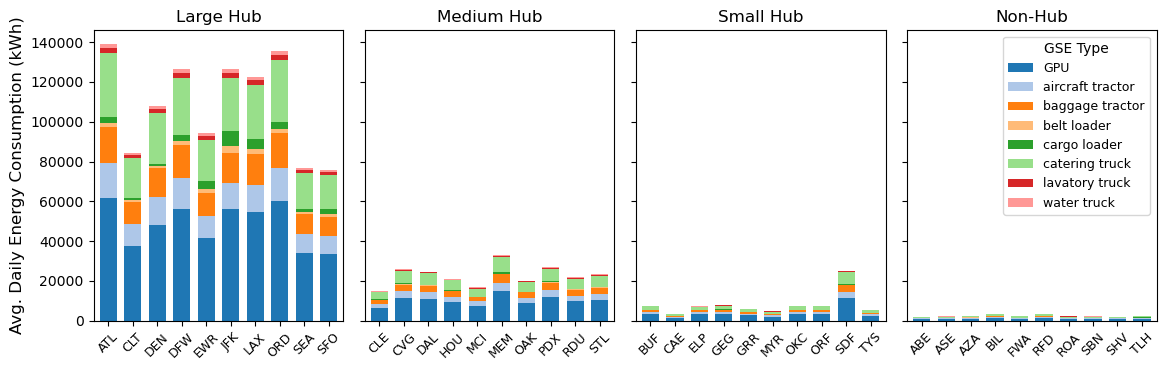

In [54]:
import pandas as pd
import matplotlib.pyplot as plt

# Replace this with your actual DataFrame
df = GSE_avg_energy_day_df.copy()

# Grouped airports by category
grouped_airports = {
    'Large Hub': ['ATL', 'DEN', 'DFW', 'ORD', 'LAX', 'SFO', 'SEA', 'JFK', 'CLT', 'EWR'],
    'Medium Hub': ['MEM', 'PDX', 'DAL', 'CVG', 'STL', 'OAK', 'HOU', 'RDU', 'MCI', 'CLE'],
    'Small Hub': ['SDF', 'GEG', 'OKC', 'ORF', 'BUF', 'ELP', 'MYR', 'TYS', 'CAE', 'GRR'],
    'Non-Hub': ['BIL', 'RFD', 'TLH', 'FWA', 'ROA', 'AZA', 'SHV', 'ABE', 'SBN', 'ASE']
}

colors = plt.cm.tab20.colors  # enough unique colors for GSE types

fig, axes = plt.subplots(1, 4, figsize=(12, 4), sharey=True)
axes = axes.flatten()

for i, (category, airports) in enumerate(grouped_airports.items()):
    df_subset = df[df['airport'].isin(airports)]
    
    # Pivot to get airports on x-axis and GSE types as columns
    pivot_df = df_subset.pivot_table(index='airport', columns='GSE_type', values='energy_consumption', aggfunc='sum').fillna(0)
    
    # Plot stacked bar
    pivot_df.plot(kind='bar', stacked=True, ax=axes[i], color=colors, width=0.7, legend=(i==3))  # legend only on last plot
    
    axes[i].set_xlabel(' ')
    axes[i].tick_params(axis='x', rotation=45, labelsize=9)
    if i == 0:
        axes[i].set_ylabel('Avg. Daily Energy Consumption (kWh)', fontsize=12)
    else:
        axes[i].set_ylabel('')
        axes[i].tick_params(axis='y', labelleft=False)

    axes[i].set_title(category, fontsize=12)

# Only add legend to last subplot
if 'GSE_type' in df.columns:
    handles, labels = axes[3].get_legend_handles_labels()
    axes[3].legend(handles, labels, bbox_to_anchor=(0.36, 1), loc='upper left', fontsize=9, title="GSE Type")
    
plt.tight_layout()
plt.show()

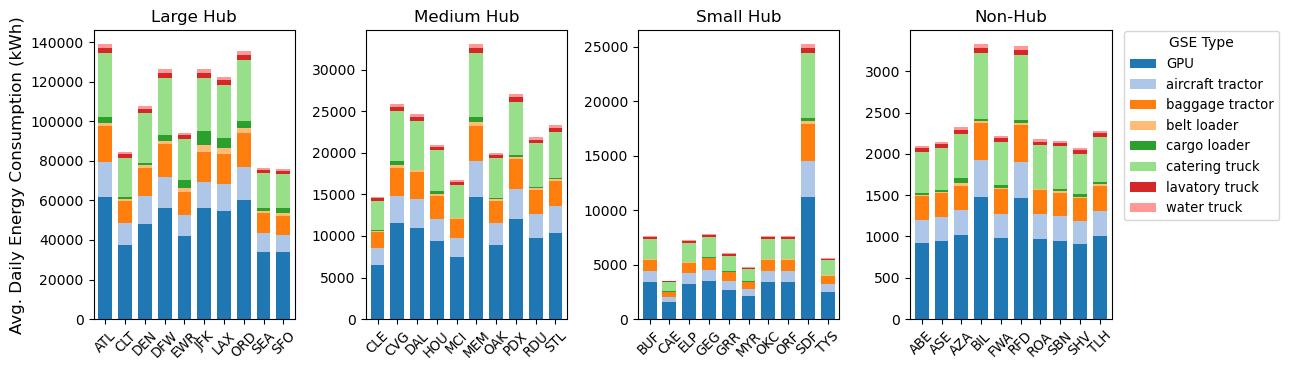

In [49]:
import pandas as pd
import matplotlib.pyplot as plt

# Replace this with your actual DataFrame
df = GSE_avg_energy_day_df.copy()

# Grouped airports by category
grouped_airports = {
    'Large Hub': ['ATL', 'DEN', 'DFW', 'ORD', 'LAX', 'SFO', 'SEA', 'JFK', 'CLT', 'EWR'],
    'Medium Hub': ['MEM', 'PDX', 'DAL', 'CVG', 'STL', 'OAK', 'HOU', 'RDU', 'MCI', 'CLE'],
    'Small Hub': ['SDF', 'GEG', 'OKC', 'ORF', 'BUF', 'ELP', 'MYR', 'TYS', 'CAE', 'GRR'],
    'Non-Hub': ['BIL', 'RFD', 'TLH', 'FWA', 'ROA', 'AZA', 'SHV', 'ABE', 'SBN', 'ASE']
}

colors = plt.cm.tab20.colors  # enough unique colors for GSE types

# Remove `sharey=True` to allow independent y-axis scaling
fig, axes = plt.subplots(1, 4, figsize=(13, 4))  
axes = axes.flatten()

for i, (category, airports) in enumerate(grouped_airports.items()):
    df_subset = df[df['airport'].isin(airports)]

    # Pivot to get airports on x-axis and GSE types as columns
    pivot_df = df_subset.pivot_table(index='airport', columns='GSE_type', values='energy_consumption', aggfunc='sum').fillna(0)

    # Plot stacked bar chart
    pivot_df.plot(kind='bar', stacked=True, ax=axes[i], color=colors, width=0.7, legend=(i == 3))

    axes[i].set_xlabel(' ')
    axes[i].tick_params(axis='x', rotation=45, labelsize=9.5)
    
    if i == 0:
        axes[i].set_ylabel('Avg. Daily Energy Consumption (kWh)', fontsize=12)
    else:
        axes[i].set_ylabel('')
        axes[i].tick_params(axis='y', left=True, labelleft=True)  # keep y-ticks for all subplots now

    axes[i].set_title(category, fontsize=12)

# Only add legend to last subplot
if 'GSE_type' in df.columns:
    handles, labels = axes[3].get_legend_handles_labels()
    axes[3].legend(handles, labels, bbox_to_anchor=(1.03, 1.02), loc='upper left', fontsize=9.5, title="GSE Type")

plt.tight_layout()
plt.show()

In [55]:
test = pd.read_csv('./all_flight_GSE_tasks/ABE_GSE_tasks.csv')
test['start_time'] = pd.to_datetime(test['start_time'])
test['date'] = test['start_time'].dt.date
enery_day = test.groupby(['date', 'GSE_type']).agg({'energy_consumption': 'sum'}).reset_index()
avg_energy_day = enery_day.groupby('GSE_type').agg({'energy_consumption': 'mean'}).reset_index()
avg_energy_day

,GSE_type,energy_consumption
0,GPU,921.636986
1,aircraft tractor,283.729508
2,baggage tractor,278.921575
3,belt loader,13.818021
4,cargo loader,30.333333
5,catering truck,498.321005
6,lavatory truck,40.962329
7,water truck,27.315068


In [64]:
# choose 10 airports from each category to represent energy consumption
large_5_airports = ['ATL', 'DEN', 'DFW', 'ORD', 'LAX', 'SFO', 'SEA', 'JFK', 'CLT', 'EWR']
medium_5_airports = ['MEM', 'PDX', 'DAL', 'CVG', 'STL', 'OAK', 'HOU', 'RDU', 'MCI', 'CLE']
small_5_airports = ['SDF', 'GEG', 'OKC', 'ORF', 'BUF', 'ELP', 'MYR', 'TYS', 'CAE', 'GRR']
nonhub_5_airports = ['BIL', 'RFD', 'TLH', 'FWA', 'ROA', 'AZA', 'SHV', 'ABE', 'SBN', 'ASE']

### Figure 3

In [3]:
load_profiles_S1_path = Path('./all_flight_load_profiles/S1_SOC_insufficient_40')
load_profiles_S2_path = Path('./all_flight_load_profiles/S2_SOC_insufficient_20')
load_profiles_S3_path = Path('./all_flight_load_profiles/S3_charge_during_service_gaps_40')
load_profiles_S4_path = Path('./all_flight_load_profiles/S4_charge_during_service_gaps_20')
load_profiles_S5_path = Path('./all_flight_load_profiles/S5_charge_overnight_40')
load_profiles_S6_path = Path('./all_flight_load_profiles/S6_charge_overnight_20')

In [104]:
# Get peak demand for each airport in scenario 1
load_S1 = glob.glob(os.path.join(load_profiles_S1_path, '*.csv'))

airport_list = []
peak_demand_list = []

for file_path in load_S1:
    df_temp = pd.read_csv(file_path)
    airport = os.path.basename(file_path).split('_')[0]
    peak_demand = df_temp['power'].max()
    airport_list.append(airport)
    peak_demand_list.append(peak_demand)

peak_demand_df_S1 = pd.DataFrame({'airport':airport_list, 'peak_demand': peak_demand_list})

In [32]:
peak_demand_df_S1['peak_demand'].max()

15760

In [33]:
us_airports_gps = pd.read_csv('./us_airports_gps.csv')
us_airports_gps = us_airports_gps.dropna(subset='iata_code')

In [34]:
peak_demand_df_S1_location = pd.merge(peak_demand_df_S1, us_airports_gps[['iata_code', 'latitude_deg', 'longitude_deg', 'region_name']], left_on='airport', right_on='iata_code', how='inner')

In [35]:
import geopandas as gpd
from shapely.geometry import Point
peak_demand_df_S1_location['geometry'] = peak_demand_df_S1_location.apply(lambda row: Point(row['longitude_deg'], row['latitude_deg']), axis=1)
peak_demand_df_S1_location_gdf = gpd.GeoDataFrame(peak_demand_df_S1_location, geometry='geometry', crs='EPSG:4326')

In [36]:
peak_demand_df_S1_large = peak_demand_df_S1_location_gdf[peak_demand_df_S1_location_gdf['airport'].isin(annual_flight_count_mainland_large['airport'].to_list())]
peak_demand_df_S1_medium = peak_demand_df_S1_location_gdf[peak_demand_df_S1_location_gdf['airport'].isin(annual_flight_count_mainland_medium['airport'].to_list())]
peak_demand_df_S1_small= peak_demand_df_S1_location_gdf[peak_demand_df_S1_location_gdf['airport'].isin(annual_flight_count_mainland_small['airport'].to_list())]
peak_demand_df_S1_nonhub = peak_demand_df_S1_location_gdf[peak_demand_df_S1_location_gdf['airport'].isin(annual_flight_count_mainland_non_hub['airport'].to_list())]

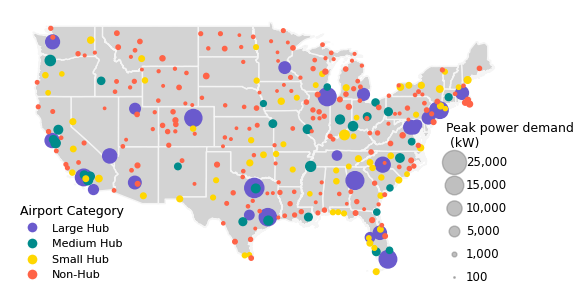

In [37]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.lines import Line2D


# Update this path to where you extracted the Natural Earth shapefile
shapefile_path = "./US_State_Boundaries/US_State_Boundaries.shp"

# Load the shapefile into a GeoDataFrame
us = gpd.read_file(shapefile_path)

# Filter for US mainland (excluding Alaska and Hawaii)
us_mainland = us[(us['NAME'] != 'Puerto Rico') & (us['NAME'] != 'Hawaii') & (us['NAME'] != 'Alaska') & (us['NAME'] !='U.S. Virgin Islands')]

# Set up plot
fig, ax = plt.subplots(figsize=(6, 4))

# Normalize size
max_size = 25000
scale_factor = 300
normalize_size = lambda x: (x / max_size) * scale_factor

# Plot base map
us_mainland.plot(ax=ax, color='lightgrey', edgecolor='whitesmoke')

# Plot airport categories
peak_demand_df_S1_large.plot(ax=ax, markersize=normalize_size(peak_demand_df_S1_large['peak_demand']), color='slateblue', label='Large Hub')
peak_demand_df_S1_medium.plot(ax=ax, markersize=normalize_size(peak_demand_df_S1_medium['peak_demand']), color='darkcyan', label='Medium Hub')
peak_demand_df_S1_small.plot(ax=ax, markersize=normalize_size(peak_demand_df_S1_small['peak_demand']), color='gold', label='Small Hub')
peak_demand_df_S1_nonhub.plot(ax=ax, markersize=normalize_size(peak_demand_df_S1_nonhub['peak_demand']), color='tomato', label='Non-Hub')

# Custom legend for color (category)
color_legend = [
    Line2D([0], [0], marker='o', color='w', label='Large Hub', markerfacecolor='slateblue', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Medium Hub', markerfacecolor='darkcyan', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Small Hub', markerfacecolor='gold', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Non-Hub', markerfacecolor='tomato', markersize=8)
]
legend1 = ax.legend(handles=color_legend, title='Airport Category', loc = 'lower left', fontsize=8, title_fontsize=9)
ax.add_artist(legend1)
legend1.get_frame().set_linewidth(0)

# Custom size scale (marker size)
example_counts = [100, 1000, 5000, 10000, 15000, 25000]  # adjust as needed
x_pos, y_pos = -125, 24  # adjust position to fit map
for i, count in enumerate(example_counts):
    y = y_pos + i * 2.3
    size = normalize_size(count)
    ax.scatter(x_pos+53, y, s=size, color='gray', alpha=0.5)
    ax.text(x_pos + 54.5, y, f'{count:,}', va='center', fontsize=8.5)

ax.text(x_pos+52, y_pos + len(example_counts)*2+1, 'Peak power demand\n (kW)', fontsize=9)

# Remove border and axes
ax.set_axis_off()
plt.tight_layout()
plt.show()

In [38]:
# Get peak demand for each airport in scenario 2
load_S2 = glob.glob(os.path.join(load_profiles_S2_path, '*.csv'))

airport_list = []
peak_demand_list = []

for file_path in load_S2:
    df_temp = pd.read_csv(file_path)
    airport = os.path.basename(file_path).split('_')[0]
    peak_demand = df_temp['power'].max()
    airport_list.append(airport)
    peak_demand_list.append(peak_demand)

peak_demand_df_S2 = pd.DataFrame({'airport':airport_list, 'peak_demand': peak_demand_list})

In [39]:
peak_demand_df_S2_location = pd.merge(peak_demand_df_S2, us_airports_gps[['iata_code', 'latitude_deg', 'longitude_deg', 'region_name']], left_on='airport', right_on='iata_code', how='inner')
peak_demand_df_S2_location['geometry'] = peak_demand_df_S2_location.apply(lambda row: Point(row['longitude_deg'], row['latitude_deg']), axis=1)
peak_demand_df_S2_location_gdf = gpd.GeoDataFrame(peak_demand_df_S2_location, geometry='geometry', crs='EPSG:4326')

In [40]:
peak_demand_df_S2_large = peak_demand_df_S2_location_gdf[peak_demand_df_S2_location_gdf['airport'].isin(annual_flight_count_mainland_large['airport'].to_list())]
peak_demand_df_S2_medium = peak_demand_df_S2_location_gdf[peak_demand_df_S2_location_gdf['airport'].isin(annual_flight_count_mainland_medium['airport'].to_list())]
peak_demand_df_S2_small= peak_demand_df_S2_location_gdf[peak_demand_df_S2_location_gdf['airport'].isin(annual_flight_count_mainland_small['airport'].to_list())]
peak_demand_df_S2_nonhub = peak_demand_df_S2_location_gdf[peak_demand_df_S2_location_gdf['airport'].isin(annual_flight_count_mainland_non_hub['airport'].to_list())]

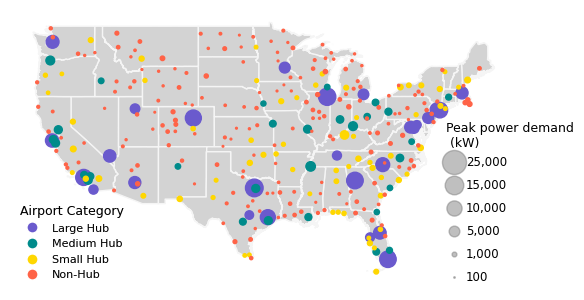

In [41]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.lines import Line2D


# Update this path to where you extracted the Natural Earth shapefile
shapefile_path = "./US_State_Boundaries/US_State_Boundaries.shp"

# Load the shapefile into a GeoDataFrame
us = gpd.read_file(shapefile_path)

# Filter for US mainland (excluding Alaska and Hawaii)
us_mainland = us[(us['NAME'] != 'Puerto Rico') & (us['NAME'] != 'Hawaii') & (us['NAME'] != 'Alaska') & (us['NAME'] !='U.S. Virgin Islands')]

# Set up plot
fig, ax = plt.subplots(figsize=(6, 4))

# Normalize size
max_size = 25000
scale_factor = 300
normalize_size = lambda x: (x / max_size) * scale_factor

# Plot base map
us_mainland.plot(ax=ax, color='lightgrey', edgecolor='whitesmoke')

# Plot airport categories
peak_demand_df_S2_large.plot(ax=ax, markersize=normalize_size(peak_demand_df_S2_large['peak_demand']), color='slateblue', label='Large Hub')
peak_demand_df_S2_medium.plot(ax=ax, markersize=normalize_size(peak_demand_df_S2_medium['peak_demand']), color='darkcyan', label='Medium Hub')
peak_demand_df_S2_small.plot(ax=ax, markersize=normalize_size(peak_demand_df_S2_small['peak_demand']), color='gold', label='Small Hub')
peak_demand_df_S2_nonhub.plot(ax=ax, markersize=normalize_size(peak_demand_df_S2_nonhub['peak_demand']), color='tomato', label='Non-Hub')

# Custom legend for color (category)
color_legend = [
    Line2D([0], [0], marker='o', color='w', label='Large Hub', markerfacecolor='slateblue', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Medium Hub', markerfacecolor='darkcyan', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Small Hub', markerfacecolor='gold', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Non-Hub', markerfacecolor='tomato', markersize=8)
]
legend1 = ax.legend(handles=color_legend, title='Airport Category', loc = 'lower left', fontsize=8, title_fontsize=9)
ax.add_artist(legend1)
legend1.get_frame().set_linewidth(0)

# Custom size scale (marker size)
example_counts = [100, 1000, 5000, 10000, 15000, 25000]  # adjust as needed
x_pos, y_pos = -125, 24  # adjust position to fit map
for i, count in enumerate(example_counts):
    y = y_pos + i * 2.3
    size = normalize_size(count)
    ax.scatter(x_pos+53, y, s=size, color='gray', alpha=0.5)
    ax.text(x_pos + 54.5, y, f'{count:,}', va='center', fontsize=8.5)

ax.text(x_pos+52, y_pos + len(example_counts)*2+1, 'Peak power demand\n (kW)', fontsize=9)

# Remove border and axes
ax.set_axis_off()
plt.tight_layout()
plt.show()

In [42]:
# Get peak demand for each airport in scenario 3
load_S3 = glob.glob(os.path.join(load_profiles_S3_path, '*.csv'))

airport_list = []
peak_demand_list = []

for file_path in load_S3:
    df_temp = pd.read_csv(file_path)
    airport = os.path.basename(file_path).split('_')[0]
    peak_demand = df_temp['power'].max()
    airport_list.append(airport)
    peak_demand_list.append(peak_demand)

peak_demand_df_S3 = pd.DataFrame({'airport':airport_list, 'peak_demand': peak_demand_list})

In [43]:
peak_demand_df_S3_location = pd.merge(peak_demand_df_S3, us_airports_gps[['iata_code', 'latitude_deg', 'longitude_deg', 'region_name']], left_on='airport', right_on='iata_code', how='inner')
peak_demand_df_S3_location['geometry'] = peak_demand_df_S3_location.apply(lambda row: Point(row['longitude_deg'], row['latitude_deg']), axis=1)
peak_demand_df_S3_location_gdf = gpd.GeoDataFrame(peak_demand_df_S3_location, geometry='geometry', crs='EPSG:4326')

In [44]:
peak_demand_df_S3_location_gdf['peak_demand'].max()

18400

In [45]:
peak_demand_df_S3_large = peak_demand_df_S3_location_gdf[peak_demand_df_S3_location_gdf['airport'].isin(annual_flight_count_mainland_large['airport'].to_list())]
peak_demand_df_S3_medium = peak_demand_df_S3_location_gdf[peak_demand_df_S3_location_gdf['airport'].isin(annual_flight_count_mainland_medium['airport'].to_list())]
peak_demand_df_S3_small= peak_demand_df_S3_location_gdf[peak_demand_df_S3_location_gdf['airport'].isin(annual_flight_count_mainland_small['airport'].to_list())]
peak_demand_df_S3_nonhub = peak_demand_df_S3_location_gdf[peak_demand_df_S3_location_gdf['airport'].isin(annual_flight_count_mainland_non_hub['airport'].to_list())]

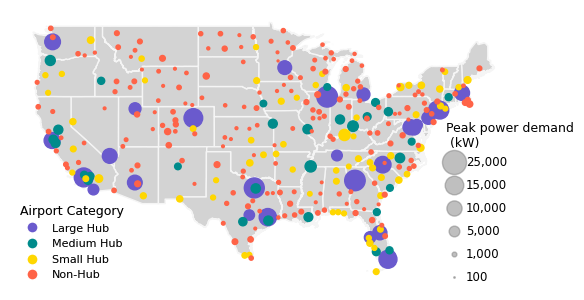

In [46]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.lines import Line2D


# Update this path to where you extracted the Natural Earth shapefile
shapefile_path = "./US_State_Boundaries/US_State_Boundaries.shp"

# Load the shapefile into a GeoDataFrame
us = gpd.read_file(shapefile_path)

# Filter for US mainland (excluding Alaska and Hawaii)
us_mainland = us[(us['NAME'] != 'Puerto Rico') & (us['NAME'] != 'Hawaii') & (us['NAME'] != 'Alaska') & (us['NAME'] !='U.S. Virgin Islands')]

# Set up plot
fig, ax = plt.subplots(figsize=(6, 4))

# Normalize size
max_size = 25000
scale_factor = 300
normalize_size = lambda x: (x / max_size) * scale_factor

# Plot base map
us_mainland.plot(ax=ax, color='lightgrey', edgecolor='whitesmoke')

# Plot airport categories
peak_demand_df_S3_large.plot(ax=ax, markersize=normalize_size(peak_demand_df_S3_large['peak_demand']), color='slateblue', label='Large Hub')
peak_demand_df_S3_medium.plot(ax=ax, markersize=normalize_size(peak_demand_df_S3_medium['peak_demand']), color='darkcyan', label='Medium Hub')
peak_demand_df_S3_small.plot(ax=ax, markersize=normalize_size(peak_demand_df_S3_small['peak_demand']), color='gold', label='Small Hub')
peak_demand_df_S3_nonhub.plot(ax=ax, markersize=normalize_size(peak_demand_df_S3_nonhub['peak_demand']), color='tomato', label='Non-Hub')

# Custom legend for color (category)
color_legend = [
    Line2D([0], [0], marker='o', color='w', label='Large Hub', markerfacecolor='slateblue', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Medium Hub', markerfacecolor='darkcyan', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Small Hub', markerfacecolor='gold', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Non-Hub', markerfacecolor='tomato', markersize=8)
]
legend1 = ax.legend(handles=color_legend, title='Airport Category', loc = 'lower left', fontsize=8, title_fontsize=9)
ax.add_artist(legend1)
legend1.get_frame().set_linewidth(0)

# Custom size scale (marker size)
example_counts = [100, 1000, 5000, 10000, 15000, 25000]  # adjust as needed
x_pos, y_pos = -125, 24  # adjust position to fit map
for i, count in enumerate(example_counts):
    y = y_pos + i * 2.3
    size = normalize_size(count)
    ax.scatter(x_pos+53, y, s=size, color='gray', alpha=0.5)
    ax.text(x_pos + 54.5, y, f'{count:,}', va='center', fontsize=8.5)

ax.text(x_pos+52, y_pos + len(example_counts)*2+1, 'Peak power demand\n (kW)', fontsize=9)

# Remove border and axes
ax.set_axis_off()
plt.tight_layout()
plt.show()

In [47]:
# Get peak demand for each airport in scenario 4
load_S4 = glob.glob(os.path.join(load_profiles_S4_path, '*.csv'))

airport_list = []
peak_demand_list = []

for file_path in load_S4:
    df_temp = pd.read_csv(file_path)
    airport = os.path.basename(file_path).split('_')[0]
    peak_demand = df_temp['power'].max()
    airport_list.append(airport)
    peak_demand_list.append(peak_demand)

peak_demand_df_S4 = pd.DataFrame({'airport':airport_list, 'peak_demand': peak_demand_list})

In [48]:
peak_demand_df_S4_location = pd.merge(peak_demand_df_S4, us_airports_gps[['iata_code', 'latitude_deg', 'longitude_deg', 'region_name']], left_on='airport', right_on='iata_code', how='inner')
peak_demand_df_S4_location['geometry'] = peak_demand_df_S4_location.apply(lambda row: Point(row['longitude_deg'], row['latitude_deg']), axis=1)
peak_demand_df_S4_location_gdf = gpd.GeoDataFrame(peak_demand_df_S4_location, geometry='geometry', crs='EPSG:4326')

In [49]:
peak_demand_df_S4_large = peak_demand_df_S4_location_gdf[peak_demand_df_S4_location_gdf['airport'].isin(annual_flight_count_mainland_large['airport'].to_list())]
peak_demand_df_S4_medium = peak_demand_df_S4_location_gdf[peak_demand_df_S4_location_gdf['airport'].isin(annual_flight_count_mainland_medium['airport'].to_list())]
peak_demand_df_S4_small= peak_demand_df_S4_location_gdf[peak_demand_df_S4_location_gdf['airport'].isin(annual_flight_count_mainland_small['airport'].to_list())]
peak_demand_df_S4_nonhub = peak_demand_df_S4_location_gdf[peak_demand_df_S4_location_gdf['airport'].isin(annual_flight_count_mainland_non_hub['airport'].to_list())]

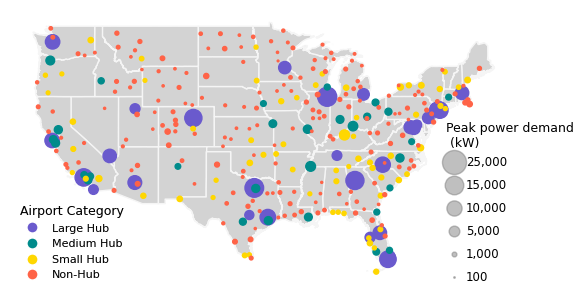

In [50]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.lines import Line2D


# Update this path to where you extracted the Natural Earth shapefile
shapefile_path = "./US_State_Boundaries/US_State_Boundaries.shp"

# Load the shapefile into a GeoDataFrame
us = gpd.read_file(shapefile_path)

# Filter for US mainland (excluding Alaska and Hawaii)
us_mainland = us[(us['NAME'] != 'Puerto Rico') & (us['NAME'] != 'Hawaii') & (us['NAME'] != 'Alaska') & (us['NAME'] !='U.S. Virgin Islands')]

# Set up plot
fig, ax = plt.subplots(figsize=(6, 4))

# Normalize size
max_size = 25000
scale_factor = 300
normalize_size = lambda x: (x / max_size) * scale_factor

# Plot base map
us_mainland.plot(ax=ax, color='lightgrey', edgecolor='whitesmoke')

# Plot airport categories
peak_demand_df_S4_large.plot(ax=ax, markersize=normalize_size(peak_demand_df_S4_large['peak_demand']), color='slateblue', label='Large Hub')
peak_demand_df_S4_medium.plot(ax=ax, markersize=normalize_size(peak_demand_df_S4_medium['peak_demand']), color='darkcyan', label='Medium Hub')
peak_demand_df_S4_small.plot(ax=ax, markersize=normalize_size(peak_demand_df_S4_small['peak_demand']), color='gold', label='Small Hub')
peak_demand_df_S4_nonhub.plot(ax=ax, markersize=normalize_size(peak_demand_df_S4_nonhub['peak_demand']), color='tomato', label='Non-Hub')

# Custom legend for color (category)
color_legend = [
    Line2D([0], [0], marker='o', color='w', label='Large Hub', markerfacecolor='slateblue', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Medium Hub', markerfacecolor='darkcyan', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Small Hub', markerfacecolor='gold', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Non-Hub', markerfacecolor='tomato', markersize=8)
]
legend1 = ax.legend(handles=color_legend, title='Airport Category', loc = 'lower left', fontsize=8, title_fontsize=9)
ax.add_artist(legend1)
legend1.get_frame().set_linewidth(0)

# Custom size scale (marker size)
example_counts = [100, 1000, 5000, 10000, 15000, 25000]  # adjust as needed
x_pos, y_pos = -125, 24  # adjust position to fit map
for i, count in enumerate(example_counts):
    y = y_pos + i * 2.3
    size = normalize_size(count)
    ax.scatter(x_pos+53, y, s=size, color='gray', alpha=0.5)
    ax.text(x_pos + 54.5, y, f'{count:,}', va='center', fontsize=8.5)

ax.text(x_pos+52, y_pos + len(example_counts)*2+1, 'Peak power demand\n (kW)', fontsize=9)

# Remove border and axes
ax.set_axis_off()
plt.tight_layout()
plt.show()

In [13]:
# Get peak demand for each airport in scenario 5
load_S5 = glob.glob(os.path.join(load_profiles_S5_path, '*.csv'))

airport_list = []
peak_demand_list = []

for file_path in load_S5:
    df_temp = pd.read_csv(file_path)
    airport = os.path.basename(file_path).split('_')[0]
    peak_demand = df_temp['power'].max()
    airport_list.append(airport)
    peak_demand_list.append(peak_demand)

peak_demand_df_S5 = pd.DataFrame({'airport':airport_list, 'peak_demand': peak_demand_list})

In [14]:
peak_demand_df_S5_location = pd.merge(peak_demand_df_S5, us_airports_gps[['iata_code', 'latitude_deg', 'longitude_deg', 'region_name']], left_on='airport', right_on='iata_code', how='inner')
peak_demand_df_S5_location['geometry'] = peak_demand_df_S5_location.apply(lambda row: Point(row['longitude_deg'], row['latitude_deg']), axis=1)
peak_demand_df_S5_location_gdf = gpd.GeoDataFrame(peak_demand_df_S5_location, geometry='geometry', crs='EPSG:4326')

In [17]:
peak_demand_df_S5_location_gdf['peak_demand'].max()

25480

In [15]:
peak_demand_df_S5_large = peak_demand_df_S5_location_gdf[peak_demand_df_S5_location_gdf['airport'].isin(annual_flight_count_mainland_large['airport'].to_list())]
peak_demand_df_S5_medium = peak_demand_df_S5_location_gdf[peak_demand_df_S5_location_gdf['airport'].isin(annual_flight_count_mainland_medium['airport'].to_list())]
peak_demand_df_S5_small= peak_demand_df_S5_location_gdf[peak_demand_df_S5_location_gdf['airport'].isin(annual_flight_count_mainland_small['airport'].to_list())]
peak_demand_df_S5_nonhub = peak_demand_df_S5_location_gdf[peak_demand_df_S5_location_gdf['airport'].isin(annual_flight_count_mainland_non_hub['airport'].to_list())]

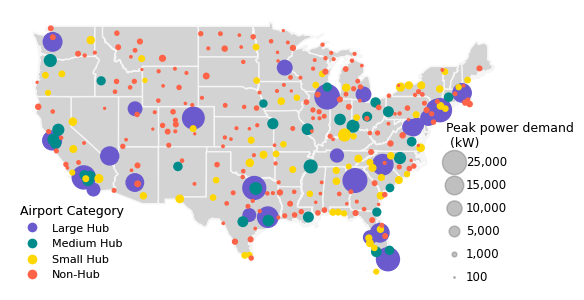

In [23]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.lines import Line2D


# Update this path to where you extracted the Natural Earth shapefile
shapefile_path = "./US_State_Boundaries/US_State_Boundaries.shp"

# Load the shapefile into a GeoDataFrame
us = gpd.read_file(shapefile_path)

# Filter for US mainland (excluding Alaska and Hawaii)
us_mainland = us[(us['NAME'] != 'Puerto Rico') & (us['NAME'] != 'Hawaii') & (us['NAME'] != 'Alaska') & (us['NAME'] !='U.S. Virgin Islands')]

# Set up plot
fig, ax = plt.subplots(figsize=(6, 4))

# Normalize size
max_size = 25000
scale_factor = 300
normalize_size = lambda x: (x / max_size) * scale_factor

# Plot base map
us_mainland.plot(ax=ax, color='lightgrey', edgecolor='whitesmoke')

# Plot airport categories
peak_demand_df_S5_large.plot(ax=ax, markersize=normalize_size(peak_demand_df_S5_large['peak_demand']), color='slateblue', label='Large Hub')
peak_demand_df_S5_medium.plot(ax=ax, markersize=normalize_size(peak_demand_df_S5_medium['peak_demand']), color='darkcyan', label='Medium Hub')
peak_demand_df_S5_small.plot(ax=ax, markersize=normalize_size(peak_demand_df_S5_small['peak_demand']), color='gold', label='Small Hub')
peak_demand_df_S5_nonhub.plot(ax=ax, markersize=normalize_size(peak_demand_df_S5_nonhub['peak_demand']), color='tomato', label='Non-Hub')

# Custom legend for color (category)
color_legend = [
    Line2D([0], [0], marker='o', color='w', label='Large Hub', markerfacecolor='slateblue', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Medium Hub', markerfacecolor='darkcyan', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Small Hub', markerfacecolor='gold', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Non-Hub', markerfacecolor='tomato', markersize=8)
]
legend1 = ax.legend(handles=color_legend, title='Airport Category', loc = 'lower left', fontsize=8, title_fontsize=9)
ax.add_artist(legend1)
legend1.get_frame().set_linewidth(0)

# Custom size scale (marker size)
example_counts = [100, 1000, 5000, 10000, 15000, 25000]  # adjust as needed
x_pos, y_pos = -125, 24  # adjust position to fit map
for i, count in enumerate(example_counts):
    y = y_pos + i * 2.3
    size = normalize_size(count)
    ax.scatter(x_pos+53, y, s=size, color='gray', alpha=0.5)
    ax.text(x_pos + 54.5, y, f'{count:,}', va='center', fontsize=8.5)

ax.text(x_pos+52, y_pos + len(example_counts)*2+1, 'Peak power demand\n (kW)', fontsize=9)

# Remove border and axes
ax.set_axis_off()
plt.tight_layout()
plt.show()

In [24]:
# Get peak demand for each airport in scenario 6
load_S6 = glob.glob(os.path.join(load_profiles_S6_path, '*.csv'))

airport_list = []
peak_demand_list = []

for file_path in load_S6:
    df_temp = pd.read_csv(file_path)
    airport = os.path.basename(file_path).split('_')[0]
    peak_demand = df_temp['power'].max()
    airport_list.append(airport)
    peak_demand_list.append(peak_demand)

peak_demand_df_S6 = pd.DataFrame({'airport':airport_list, 'peak_demand': peak_demand_list})

In [26]:
peak_demand_df_S6_location = pd.merge(peak_demand_df_S6, us_airports_gps[['iata_code', 'latitude_deg', 'longitude_deg', 'region_name']], left_on='airport', right_on='iata_code', how='inner')
peak_demand_df_S6_location['geometry'] = peak_demand_df_S6_location.apply(lambda row: Point(row['longitude_deg'], row['latitude_deg']), axis=1)
peak_demand_df_S6_location_gdf = gpd.GeoDataFrame(peak_demand_df_S6_location, geometry='geometry', crs='EPSG:4326')

In [27]:
peak_demand_df_S6_location_gdf['peak_demand'].max()

20220

In [28]:
peak_demand_df_S6_large = peak_demand_df_S6_location_gdf[peak_demand_df_S6_location_gdf['airport'].isin(annual_flight_count_mainland_large['airport'].to_list())]
peak_demand_df_S6_medium = peak_demand_df_S6_location_gdf[peak_demand_df_S6_location_gdf['airport'].isin(annual_flight_count_mainland_medium['airport'].to_list())]
peak_demand_df_S6_small= peak_demand_df_S6_location_gdf[peak_demand_df_S6_location_gdf['airport'].isin(annual_flight_count_mainland_small['airport'].to_list())]
peak_demand_df_S6_nonhub = peak_demand_df_S6_location_gdf[peak_demand_df_S6_location_gdf['airport'].isin(annual_flight_count_mainland_non_hub['airport'].to_list())]

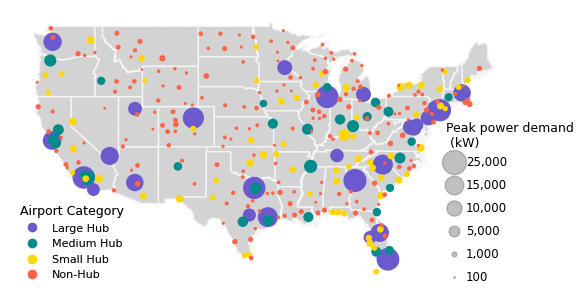

In [29]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.lines import Line2D


# Update this path to where you extracted the Natural Earth shapefile
shapefile_path = "./US_State_Boundaries/US_State_Boundaries.shp"

# Load the shapefile into a GeoDataFrame
us = gpd.read_file(shapefile_path)

# Filter for US mainland (excluding Alaska and Hawaii)
us_mainland = us[(us['NAME'] != 'Puerto Rico') & (us['NAME'] != 'Hawaii') & (us['NAME'] != 'Alaska') & (us['NAME'] !='U.S. Virgin Islands')]

# Set up plot
fig, ax = plt.subplots(figsize=(6, 4))

# Normalize size
max_size = 25000
scale_factor = 300
normalize_size = lambda x: (x / max_size) * scale_factor

# Plot base map
us_mainland.plot(ax=ax, color='lightgrey', edgecolor='whitesmoke')

# Plot airport categories
peak_demand_df_S6_large.plot(ax=ax, markersize=normalize_size(peak_demand_df_S6_large['peak_demand']), color='slateblue', label='Large Hub')
peak_demand_df_S6_medium.plot(ax=ax, markersize=normalize_size(peak_demand_df_S6_medium['peak_demand']), color='darkcyan', label='Medium Hub')
peak_demand_df_S6_small.plot(ax=ax, markersize=normalize_size(peak_demand_df_S6_small['peak_demand']), color='gold', label='Small Hub')
peak_demand_df_S6_nonhub.plot(ax=ax, markersize=normalize_size(peak_demand_df_S6_nonhub['peak_demand']), color='tomato', label='Non-Hub')

# Custom legend for color (category)
color_legend = [
    Line2D([0], [0], marker='o', color='w', label='Large Hub', markerfacecolor='slateblue', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Medium Hub', markerfacecolor='darkcyan', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Small Hub', markerfacecolor='gold', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Non-Hub', markerfacecolor='tomato', markersize=8)
]
legend1 = ax.legend(handles=color_legend, title='Airport Category', loc = 'lower left', fontsize=8, title_fontsize=9)
ax.add_artist(legend1)
legend1.get_frame().set_linewidth(0)

# Custom size scale (marker size)
example_counts = [100, 1000, 5000, 10000, 15000, 25000]  # adjust as needed
x_pos, y_pos = -125, 24  # adjust position to fit map
for i, count in enumerate(example_counts):
    y = y_pos + i * 2.3
    size = normalize_size(count)
    ax.scatter(x_pos+53, y, s=size, color='gray', alpha=0.5)
    ax.text(x_pos + 54.5, y, f'{count:,}', va='center', fontsize=8.5)

ax.text(x_pos+52, y_pos + len(example_counts)*2+1, 'Peak power demand\n (kW)', fontsize=9)

# Remove border and axes
ax.set_axis_off()
plt.tight_layout()
plt.show()

In [ ]:
# import matplotlib.pyplot as plt
# import matplotlib.dates as mdates
# for file in load:
#     test = pd.read_csv(file)
#     test['time'] = pd.to_datetime(test['time_stamp'])
#     fig, ax = plt.subplots(figsize=(15, 7))
#     airport = os.path.basename(file).split('_')[0]
#     ax.plot(test.time, test.power)
#     # ax.xaxis.set_major_formatter(mdates.DateFormatter('%d'))  # Format as HH:MM
#     # ax.xaxis.set_major_locator(mdates.HourLocator(interval=3))  # Show tick every 3 hours
#     plt.xlabel("Time", fontsize  = 14)
#     plt.ylabel("Power demand (kW)", fontsize  = 14)
#     plt.title(f"{airport} GSE Load Profile", fontsize  = 14)
#     plt.show()

### Figure 2

In [ ]:
load_S1 = glob.glob(os.path.join(load_profiles_S1_path, '*.csv'))

dic_load_all_airports_S1 = {}

for file_path in load_S1:
    df_temp = pd.read_csv(file_path)
    airport = os.path.basename(file_path).split('_')[0]

    temp_load_profile = df_temp[df_temp['time_stamp'].str.contains(('2023-10-20'))]
    temp_load_profile['time_stamp'] = pd.to_datetime(temp_load_profile['time_stamp'], format="%Y-%m-%d %H:%M:%S")
    temp_load_profile = temp_load_profile.sort_values(by='time_stamp')
    power_list = temp_load_profile.power.to_list()
    dic_load_all_airports_S1[airport] = power_list

/tmp/ipykernel_345046/2612785768.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_load_profile['time_stamp'] = pd.to_datetime(temp_load_profile['time_stamp'], format="%Y-%m-%d %H:%M:%S")
/tmp/ipykernel_345046/2612785768.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_load_profile['time_stamp'] = pd.to_datetime(temp_load_profile['time_stamp'], format="%Y-%m-%d %H:%M:%S")
/tmp/ipykernel_345046/2612785768.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

In [32]:
df_load_all_airports_S1 = pd.DataFrame(dic_load_all_airports_S1)

df_load_all_airports_S1_large = df_load_all_airports_S1[annual_flight_count_mainland_large['airport'].to_list()]

df_load_all_airports_S1_medium = df_load_all_airports_S1[annual_flight_count_mainland_medium['airport'].to_list()]

df_load_all_airports_S1_small = df_load_all_airports_S1[annual_flight_count_mainland_small['airport'].to_list()]

df_load_all_airports_S1_nonhub = df_load_all_airports_S1[annual_flight_count_mainland_non_hub['airport'].to_list()]


In [69]:
df_load_all_airports_S1_large.shape

(1440, 30)

In [70]:
# choose 5 airports from each category to represent daily flight arrival counts
large_5_airports = ['ATL', 'DEN', 'DFW', 'ORD', 'LAX']
medium_5_airports = ['MEM', 'PDX', 'DAL', 'CVG', 'STL']
small_5_airports = ['SDF', 'GEG', 'OKC', 'ORF', 'BUF']
nonhub_5_airports = ['BIL', 'RFD', 'TLH', 'FWA', 'ROA']

In [71]:
df_load_all_airports_S1_large_10 = df_load_all_airports_S1_large[large_5_airports]
df_load_all_airports_S1_medium_10 = df_load_all_airports_S1_medium[medium_5_airports]
df_load_all_airports_S1_small_10 = df_load_all_airports_S1_small[small_5_airports]
df_load_all_airports_S1_nonhub_10 = df_load_all_airports_S1_nonhub[nonhub_5_airports]

In [72]:
df_load_all_airports_S1_large_10

,ATL,DEN,DFW,ORD,LAX
0,7560,5240,6200,3880,7760
1,7520,5200,6120,3800,7760
2,7480,5200,6080,3760,7760
3,7400,5160,6080,3800,7680
4,7360,5160,6000,3800,7720
...,...,...,...,...,...
1435,8840,5120,8080,5720,10000
1436,8760,5120,8000,5720,9960
1437,8760,5120,7800,5720,10000
1438,8840,5120,7760,5840,9960


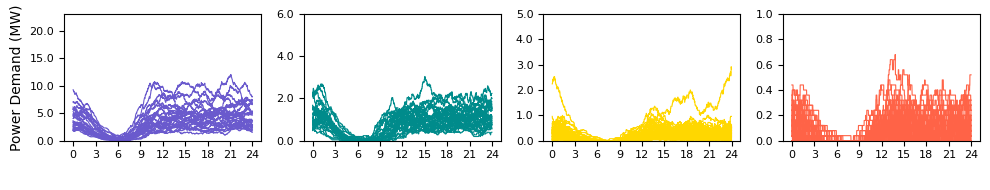

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import MaxNLocator, FormatStrFormatter


fig, axes = plt.subplots(1, 4, figsize=(10, 2), sharey=False)  # sharey=True means all share same y-axis scale
axes = axes.flatten()

df_1 = df_load_all_airports_S1_large.copy()
df_1.index = df_1.index / 60
df_1 = df_1 / 1000

df_2 = df_load_all_airports_S1_medium.copy()
df_2.index = df_2.index / 60
df_2 = df_2 / 1000

df_3 = df_load_all_airports_S1_small.copy()
df_3.index = df_3.index / 60
df_3 = df_3 / 1000

df_4 = df_load_all_airports_S1_nonhub.copy()
df_4.index = df_4.index / 60
df_4 = df_4 / 1000

df_1.iloc[:, :-3].plot(ax=axes[0], color='slateblue', legend=False, linewidth=0.8)
df_2.iloc[:, :-3].plot(ax=axes[1], color='darkcyan', legend=False, linewidth=0.8)
df_3.iloc[:, :-3].plot(ax=axes[2], color='gold', legend=False, linewidth=0.8)
df_4.iloc[:, :-3].plot(ax=axes[3], color='tomato', legend=False, linewidth=0.8)

for ax in axes:
    ax.grid(False)
    ax.tick_params(axis='y', left=True, labelleft=True, labelsize = 8)
    ax.tick_params(axis='x', labelsize = 8)

    ax.xaxis.set_major_locator(MaxNLocator(nbins=10, integer=True))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.set_xlabel(' ')

axes[0].set_ylabel('Power Demand (MW)', fontsize=10)

# Set individual y limits (replace with your actual min and max for each)
axes[0].set_ylim(0, 23)
axes[1].set_ylim(0, 6)
axes[2].set_ylim(0, 5)
axes[3].set_ylim(0, 1)

plt.tight_layout()
plt.show()

In [34]:
load_S2 = glob.glob(os.path.join(load_profiles_S2_path, '*.csv'))

dic_load_all_airports_S2 = {}

for file_path in load_S2:
    df_temp = pd.read_csv(file_path)
    airport = os.path.basename(file_path).split('_')[0]

    temp_load_profile = df_temp[df_temp['time_stamp'].str.contains(('2023-10-20'))]
    temp_load_profile['time_stamp'] = pd.to_datetime(temp_load_profile['time_stamp'], format="%Y-%m-%d %H:%M:%S")
    temp_load_profile = temp_load_profile.sort_values(by='time_stamp')
    power_list = temp_load_profile.power.to_list()
    dic_load_all_airports_S2[airport] = power_list

/tmp/ipykernel_345046/76161604.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_load_profile['time_stamp'] = pd.to_datetime(temp_load_profile['time_stamp'], format="%Y-%m-%d %H:%M:%S")
/tmp/ipykernel_345046/76161604.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_load_profile['time_stamp'] = pd.to_datetime(temp_load_profile['time_stamp'], format="%Y-%m-%d %H:%M:%S")
/tmp/ipykernel_345046/76161604.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

In [35]:
df_load_all_airports_S2 = pd.DataFrame(dic_load_all_airports_S2)

df_load_all_airports_S2_large = df_load_all_airports_S2[annual_flight_count_mainland_large['airport'].to_list()]

df_load_all_airports_S2_medium = df_load_all_airports_S2[annual_flight_count_mainland_medium['airport'].to_list()]

df_load_all_airports_S2_small = df_load_all_airports_S2[annual_flight_count_mainland_small['airport'].to_list()]

df_load_all_airports_S2_nonhub = df_load_all_airports_S2[annual_flight_count_mainland_non_hub['airport'].to_list()]


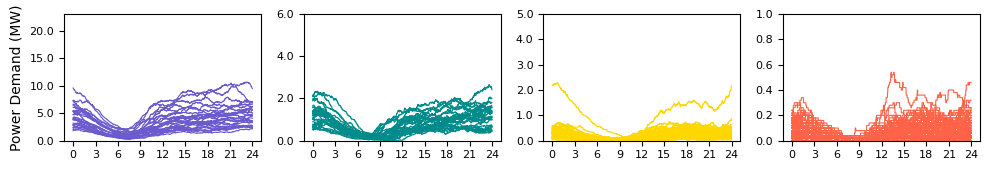

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import MaxNLocator, FormatStrFormatter


fig, axes = plt.subplots(1, 4, figsize=(10, 2), sharey=False)  # sharey=True means all share same y-axis scale
axes = axes.flatten()

df_1 = df_load_all_airports_S2_large.copy()
df_1.index = df_1.index / 60
df_1 = df_1 / 1000

df_2 = df_load_all_airports_S2_medium.copy()
df_2.index = df_2.index / 60
df_2 = df_2 / 1000

df_3 = df_load_all_airports_S2_small.copy()
df_3.index = df_3.index / 60
df_3 = df_3 / 1000

df_4 = df_load_all_airports_S2_nonhub.copy()
df_4.index = df_4.index / 60
df_4 = df_4 / 1000

df_1.iloc[:, :-3].plot(ax=axes[0], color='slateblue', legend=False, linewidth=0.8)
df_2.iloc[:, :-3].plot(ax=axes[1], color='darkcyan', legend=False, linewidth=0.8)
df_3.iloc[:, :-3].plot(ax=axes[2], color='gold', legend=False, linewidth=0.8)
df_4.iloc[:, :-3].plot(ax=axes[3], color='tomato', legend=False, linewidth=0.8)

for ax in axes:
    ax.grid(False)
    ax.tick_params(axis='y', left=True, labelleft=True, labelsize = 8)
    ax.tick_params(axis='x', labelsize = 8)

    ax.xaxis.set_major_locator(MaxNLocator(nbins=10, integer=True))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.set_xlabel(' ')

axes[0].set_ylabel('Power Demand (MW)', fontsize=10)

# Set individual y limits (replace with your actual min and max for each)
axes[0].set_ylim(0, 23)
axes[1].set_ylim(0, 6)
axes[2].set_ylim(0, 5)
axes[3].set_ylim(0, 1)

plt.tight_layout()
plt.show()

In [19]:
load_S3 = glob.glob(os.path.join(load_profiles_S3_path, '*.csv'))

dic_load_all_airports_S3 = {}

for file_path in load_S3:
    df_temp = pd.read_csv(file_path)
    airport = os.path.basename(file_path).split('_')[0]

    temp_load_profile = df_temp[df_temp['time_stamp'].str.contains(('2023-10-20'))]
    temp_load_profile['time_stamp'] = pd.to_datetime(temp_load_profile['time_stamp'], format="%Y-%m-%d %H:%M:%S")
    temp_load_profile = temp_load_profile.sort_values(by='time_stamp')
    power_list = temp_load_profile.power.to_list()
    dic_load_all_airports_S3[airport] = power_list

/tmp/ipykernel_345046/691274989.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_load_profile['time_stamp'] = pd.to_datetime(temp_load_profile['time_stamp'], format="%Y-%m-%d %H:%M:%S")
/tmp/ipykernel_345046/691274989.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_load_profile['time_stamp'] = pd.to_datetime(temp_load_profile['time_stamp'], format="%Y-%m-%d %H:%M:%S")
/tmp/ipykernel_345046/691274989.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

In [20]:
df_load_all_airports_S3 = pd.DataFrame(dic_load_all_airports_S3)

df_load_all_airports_S3_large = df_load_all_airports_S3[annual_flight_count_mainland_large['airport'].to_list()]

df_load_all_airports_S3_medium = df_load_all_airports_S3[annual_flight_count_mainland_medium['airport'].to_list()]

df_load_all_airports_S3_small = df_load_all_airports_S3[annual_flight_count_mainland_small['airport'].to_list()]

df_load_all_airports_S3_nonhub = df_load_all_airports_S3[annual_flight_count_mainland_non_hub['airport'].to_list()]


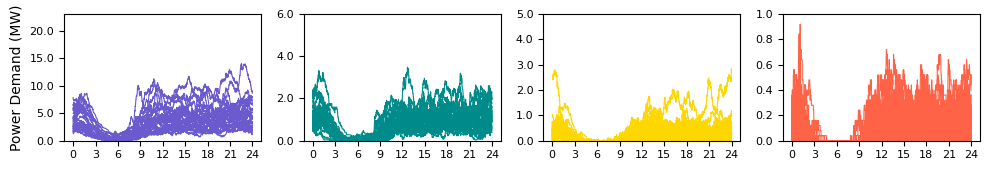

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import MaxNLocator, FormatStrFormatter


fig, axes = plt.subplots(1, 4, figsize=(10, 2), sharey=False)  # sharey=True means all share same y-axis scale
axes = axes.flatten()

df_1 = df_load_all_airports_S3_large.copy()
df_1.index = df_1.index / 60
df_1 = df_1 / 1000

df_2 = df_load_all_airports_S3_medium.copy()
df_2.index = df_2.index / 60
df_2 = df_2 / 1000

df_3 = df_load_all_airports_S3_small.copy()
df_3.index = df_3.index / 60
df_3 = df_3 / 1000

df_4 = df_load_all_airports_S3_nonhub.copy()
df_4.index = df_4.index / 60
df_4 = df_4 / 1000

df_1.iloc[:, :-3].plot(ax=axes[0], color='slateblue', legend=False, linewidth=0.8)
df_2.iloc[:, :-3].plot(ax=axes[1], color='darkcyan', legend=False, linewidth=0.8)
df_3.iloc[:, :-3].plot(ax=axes[2], color='gold', legend=False, linewidth=0.8)
df_4.iloc[:, :-3].plot(ax=axes[3], color='tomato', legend=False, linewidth=0.8)

for ax in axes:
    ax.grid(False)
    ax.tick_params(axis='y', left=True, labelleft=True, labelsize = 8)
    ax.tick_params(axis='x', labelsize = 8)

    ax.xaxis.set_major_locator(MaxNLocator(nbins=10, integer=True))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.set_xlabel(' ')

axes[0].set_ylabel('Power Demand (MW)', fontsize=10)

# Set individual y limits (replace with your actual min and max for each)
axes[0].set_ylim(0, 23)
axes[1].set_ylim(0, 6)
axes[2].set_ylim(0, 5)
axes[3].set_ylim(0, 1)

plt.tight_layout()
plt.show()

In [22]:
load_S4 = glob.glob(os.path.join(load_profiles_S4_path, '*.csv'))

dic_load_all_airports_S4 = {}

for file_path in load_S4:
    df_temp = pd.read_csv(file_path)
    airport = os.path.basename(file_path).split('_')[0]

    temp_load_profile = df_temp[df_temp['time_stamp'].str.contains(('2023-10-20'))]
    temp_load_profile['time_stamp'] = pd.to_datetime(temp_load_profile['time_stamp'], format="%Y-%m-%d %H:%M:%S")
    temp_load_profile = temp_load_profile.sort_values(by='time_stamp')
    power_list = temp_load_profile.power.to_list()
    dic_load_all_airports_S4[airport] = power_list

/tmp/ipykernel_345046/539401918.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_load_profile['time_stamp'] = pd.to_datetime(temp_load_profile['time_stamp'], format="%Y-%m-%d %H:%M:%S")
/tmp/ipykernel_345046/539401918.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_load_profile['time_stamp'] = pd.to_datetime(temp_load_profile['time_stamp'], format="%Y-%m-%d %H:%M:%S")
/tmp/ipykernel_345046/539401918.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

In [23]:
df_load_all_airports_S4 = pd.DataFrame(dic_load_all_airports_S4)

df_load_all_airports_S4_large = df_load_all_airports_S4[annual_flight_count_mainland_large['airport'].to_list()]

df_load_all_airports_S4_medium = df_load_all_airports_S4[annual_flight_count_mainland_medium['airport'].to_list()]

df_load_all_airports_S4_small = df_load_all_airports_S4[annual_flight_count_mainland_small['airport'].to_list()]

df_load_all_airports_S4_nonhub = df_load_all_airports_S4[annual_flight_count_mainland_non_hub['airport'].to_list()]


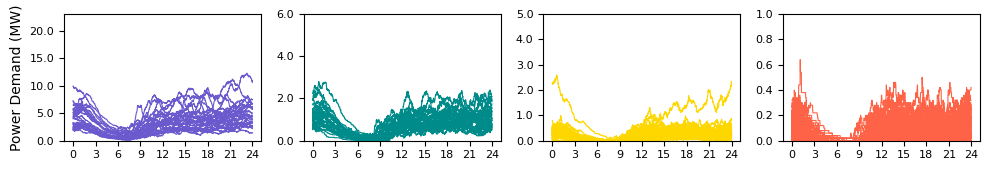

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import MaxNLocator, FormatStrFormatter


fig, axes = plt.subplots(1, 4, figsize=(10, 2), sharey=False)  # sharey=True means all share same y-axis scale
axes = axes.flatten()

df_1 = df_load_all_airports_S4_large.copy()
df_1.index = df_1.index / 60
df_1 = df_1 / 1000

df_2 = df_load_all_airports_S4_medium.copy()
df_2.index = df_2.index / 60
df_2 = df_2 / 1000

df_3 = df_load_all_airports_S4_small.copy()
df_3.index = df_3.index / 60
df_3 = df_3 / 1000

df_4 = df_load_all_airports_S4_nonhub.copy()
df_4.index = df_4.index / 60
df_4 = df_4 / 1000

df_1.iloc[:, :-3].plot(ax=axes[0], color='slateblue', legend=False, linewidth=0.8)
df_2.iloc[:, :-3].plot(ax=axes[1], color='darkcyan', legend=False, linewidth=0.8)
df_3.iloc[:, :-3].plot(ax=axes[2], color='gold', legend=False, linewidth=0.8)
df_4.iloc[:, :-3].plot(ax=axes[3], color='tomato', legend=False, linewidth=0.8)

for ax in axes:
    ax.grid(False)
    ax.tick_params(axis='y', left=True, labelleft=True, labelsize = 8)
    ax.tick_params(axis='x', labelsize = 8)

    ax.xaxis.set_major_locator(MaxNLocator(nbins=10, integer=True))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.set_xlabel(' ')

axes[0].set_ylabel('Power Demand (MW)', fontsize=10)

# Set individual y limits (replace with your actual min and max for each)
axes[0].set_ylim(0, 23)
axes[1].set_ylim(0, 6)
axes[2].set_ylim(0, 5)
axes[3].set_ylim(0, 1)

plt.tight_layout()
plt.show()

In [4]:
load_S5 = glob.glob(os.path.join(load_profiles_S5_path, '*.csv'))

dic_load_all_airports_S5 = {}

for file_path in load_S5:
    df_temp = pd.read_csv(file_path)
    airport = os.path.basename(file_path).split('_')[0]

    temp_load_profile = df_temp[df_temp['time_stamp'].str.contains(('2023-10-20'))]
    temp_load_profile['time_stamp'] = pd.to_datetime(temp_load_profile['time_stamp'], format="%Y-%m-%d %H:%M:%S")
    temp_load_profile = temp_load_profile.sort_values(by='time_stamp')
    power_list = temp_load_profile.power.to_list()
    dic_load_all_airports_S5[airport] = power_list

/tmp/ipykernel_3973880/850054236.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_load_profile['time_stamp'] = pd.to_datetime(temp_load_profile['time_stamp'], format="%Y-%m-%d %H:%M:%S")
/tmp/ipykernel_3973880/850054236.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_load_profile['time_stamp'] = pd.to_datetime(temp_load_profile['time_stamp'], format="%Y-%m-%d %H:%M:%S")
/tmp/ipykernel_3973880/850054236.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

In [23]:
df_load_all_airports_S5 = pd.DataFrame(dic_load_all_airports_S5)

df_load_all_airports_S5_large = df_load_all_airports_S5[annual_flight_count_mainland_large['airport'].to_list()]

df_load_all_airports_S5_medium = df_load_all_airports_S5[annual_flight_count_mainland_medium['airport'].to_list()]

df_load_all_airports_S5_small = df_load_all_airports_S5[annual_flight_count_mainland_small['airport'].to_list()]

df_load_all_airports_S5_nonhub = df_load_all_airports_S5[annual_flight_count_mainland_non_hub['airport'].to_list()]


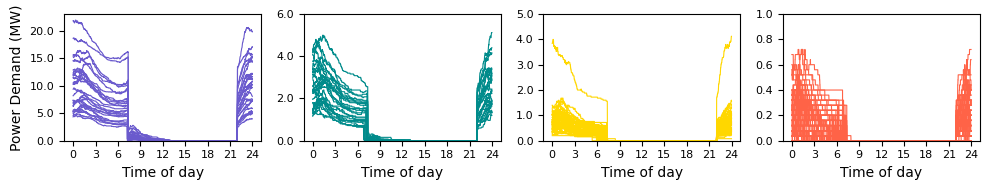

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import MaxNLocator, FormatStrFormatter


fig, axes = plt.subplots(1, 4, figsize=(10, 2), sharey=False)  # sharey=True means all share same y-axis scale
axes = axes.flatten()

df_1 = df_load_all_airports_S5_large.copy()
df_1.index = df_1.index / 60
df_1 = df_1 / 1000

df_2 = df_load_all_airports_S5_medium.copy()
df_2.index = df_2.index / 60
df_2 = df_2 / 1000

df_3 = df_load_all_airports_S5_small.copy()
df_3.index = df_3.index / 60
df_3 = df_3 / 1000

df_4 = df_load_all_airports_S5_nonhub.copy()
df_4.index = df_4.index / 60
df_4 = df_4 / 1000

df_1.iloc[:, :-3].plot(ax=axes[0], color='slateblue', legend=False, linewidth=0.8)
df_2.iloc[:, :-3].plot(ax=axes[1], color='darkcyan', legend=False, linewidth=0.8)
df_3.iloc[:, :-3].plot(ax=axes[2], color='gold', legend=False, linewidth=0.8)
df_4.iloc[:, :-3].plot(ax=axes[3], color='tomato', legend=False, linewidth=0.8)

for ax in axes:
    ax.grid(False)
    ax.tick_params(axis='y', left=True, labelleft=True, labelsize = 8)
    ax.tick_params(axis='x', labelsize = 8)

    ax.xaxis.set_major_locator(MaxNLocator(nbins=10, integer=True))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.set_xlabel('Time of day')

axes[0].set_ylabel('Power Demand (MW)', fontsize=10)

# Set individual y limits (replace with your actual min and max for each)
axes[0].set_ylim(0, 23)
axes[1].set_ylim(0, 6)
axes[2].set_ylim(0, 5)
axes[3].set_ylim(0, 1)

plt.tight_layout()
plt.show()

In [25]:
load_S6 = glob.glob(os.path.join(load_profiles_S6_path, '*.csv'))

dic_load_all_airports_S6 = {}

for file_path in load_S6:
    df_temp = pd.read_csv(file_path)
    airport = os.path.basename(file_path).split('_')[0]

    temp_load_profile = df_temp[df_temp['time_stamp'].str.contains(('2023-10-20'))]
    temp_load_profile['time_stamp'] = pd.to_datetime(temp_load_profile['time_stamp'], format="%Y-%m-%d %H:%M:%S")
    temp_load_profile = temp_load_profile.sort_values(by='time_stamp')
    power_list = temp_load_profile.power.to_list()
    dic_load_all_airports_S6[airport] = power_list

/tmp/ipykernel_3973880/2306736636.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_load_profile['time_stamp'] = pd.to_datetime(temp_load_profile['time_stamp'], format="%Y-%m-%d %H:%M:%S")
/tmp/ipykernel_3973880/2306736636.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_load_profile['time_stamp'] = pd.to_datetime(temp_load_profile['time_stamp'], format="%Y-%m-%d %H:%M:%S")
/tmp/ipykernel_3973880/2306736636.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

In [26]:
df_load_all_airports_S6 = pd.DataFrame(dic_load_all_airports_S6)

df_load_all_airports_S6_large = df_load_all_airports_S6[annual_flight_count_mainland_large['airport'].to_list()]

df_load_all_airports_S6_medium = df_load_all_airports_S6[annual_flight_count_mainland_medium['airport'].to_list()]

df_load_all_airports_S6_small = df_load_all_airports_S6[annual_flight_count_mainland_small['airport'].to_list()]

df_load_all_airports_S6_nonhub = df_load_all_airports_S6[annual_flight_count_mainland_non_hub['airport'].to_list()]


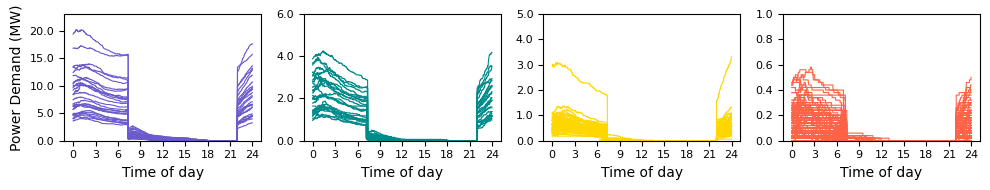

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import MaxNLocator, FormatStrFormatter


fig, axes = plt.subplots(1, 4, figsize=(10, 2), sharey=False)  # sharey=True means all share same y-axis scale
axes = axes.flatten()

df_1 = df_load_all_airports_S6_large.copy()
df_1.index = df_1.index / 60
df_1 = df_1 / 1000

df_2 = df_load_all_airports_S6_medium.copy()
df_2.index = df_2.index / 60
df_2 = df_2 / 1000

df_3 = df_load_all_airports_S6_small.copy()
df_3.index = df_3.index / 60
df_3 = df_3 / 1000

df_4 = df_load_all_airports_S6_nonhub.copy()
df_4.index = df_4.index / 60
df_4 = df_4 / 1000

df_1.iloc[:, :-3].plot(ax=axes[0], color='slateblue', legend=False, linewidth=0.8)
df_2.iloc[:, :-3].plot(ax=axes[1], color='darkcyan', legend=False, linewidth=0.8)
df_3.iloc[:, :-3].plot(ax=axes[2], color='gold', legend=False, linewidth=0.8)
df_4.iloc[:, :-3].plot(ax=axes[3], color='tomato', legend=False, linewidth=0.8)

for ax in axes:
    ax.grid(False)
    ax.tick_params(axis='y', left=True, labelleft=True, labelsize = 8)
    ax.tick_params(axis='x', labelsize = 8)

    ax.xaxis.set_major_locator(MaxNLocator(nbins=10, integer=True))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.set_xlabel('Time of day')

axes[0].set_ylabel('Power Demand (MW)', fontsize=10)

# Set individual y limits (replace with your actual min and max for each)
axes[0].set_ylim(0, 23)
axes[1].set_ylim(0, 6)
axes[2].set_ylim(0, 5)
axes[3].set_ylim(0, 1)

plt.tight_layout()
plt.show()